<a href="https://githubtocolab.com/ml-for-high-risk-apps-book/Machine-Learning-for-High-Risk-Applications-Book/blob/main/code/Chapter-10/Testing_and_Remediating_Bias_constrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 10: Testing and Remediating Bias in an XGBoost Credit Model

# Warning: some code will not run in google colab. It is recommended to download the file and use jupyter Notebook or other platforms to run the code

## 1. Setting the environment

Download the [zipped **Data** folder](https://github.com/ml-for-high-risk-apps-book/Machine-Learning-for-High-Risk-Applications-Book/blob/main/code/data_and_package.zip) onto your local system and save it as `Data.zip`.

In [ ]:
# Installing the libraries
%pip install h2o
%pip install shap
%pip install 'xgboost==1.6'

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: "'xgboost==1.6'"


## 2. Evaluating an XGBoost Model




### Train the Model

- Since the Disparate Impact Analysis(DIA) analysis will focus on model outcomes (rather than scores), choose a cutoff in probability space.


In [ ]:
!pip install xgboost
%pip install tensorflow
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import sklearn

import shap
np.random.seed(770)

import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf


Note: you may need to restart the kernel to use updated packages.


In [ ]:
data = pd.read_csv('pre_approval_denial_debias.csv')
data

,lei,derived_ethnicity,derived_race,derived_sex,loan_amount,combined_loan_to_value_ratio,property_value,income,applicant_age,derived_loan_product_type_Conventional:First Lien,...,debt_to_income_ratio_45,debt_to_income_ratio_46,debt_to_income_ratio_47,debt_to_income_ratio_48,debt_to_income_ratio_49,debt_to_income_ratio_50%-60%,debt_to_income_ratio_less20%,debt_to_income_ratio_above60%,debt_to_income_ratio_Exempt,action_taken_encoded
0,254900LEJ4HP6RMWD374,Not Hispanic or Latino,White,Female,-0.541337,-0.000076,-0.103483,-0.013646,25-34,0,...,0,0,0,0,0,0,0,0,0,0
1,5493001GDRY0EL7VG372,Not Hispanic or Latino,White,Male,0.868754,-0.001178,0.139080,-0.002412,35-44,1,...,0,0,0,0,0,0,0,0,0,0
2,QFROUN1UWUYU0DVIWD51,Not Hispanic or Latino,White,Female,-0.453207,-0.002464,-0.058564,-0.014686,55-64,1,...,0,0,0,0,0,0,0,1,0,1
3,6BYL5QZYBDK8S7L73M02,Not Hispanic or Latino,White,Joint,2.601991,-0.000721,0.426563,0.068321,45-54,1,...,0,0,0,0,0,0,0,0,0,0
4,549300T7DF901BR7V258,Ethnicity Not Available,Race Not Available,Joint,-0.071307,-0.003458,0.395119,-0.003244,55-64,1,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1032296,5493009BD405QQTMXO12,Not Hispanic or Latino,White,Male,0.075577,-0.002675,0.148064,-0.016975,25-34,1,...,0,0,0,0,1,0,0,0,0,0
1032297,COOWI3L2W9TPYR3WJX37,Ethnicity Not Available,Race Not Available,Sex Not Available,-0.776353,-0.000941,0.049242,-0.002204,35-44,0,...,0,0,0,0,0,0,0,0,0,1
1032298,549300GSCUJKJINRJ980,Not Hispanic or Latino,White,Female,-0.423830,-0.000721,-0.148402,-0.022384,45-54,1,...,0,0,0,0,0,0,0,0,0,0
1032299,549300DD4R4SYK5RAQ92,Not Hispanic or Latino,White,Female,-0.335699,0.000008,-0.152894,-0.023632,less than 25,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1032301 entries, 0 to 1032300
Data columns (total 64 columns):
 #   Column                                                            Non-Null Count    Dtype  
---  ------                                                            --------------    -----  
 0   lei                                                               1032301 non-null  object 
 1   derived_ethnicity                                                 1032301 non-null  object 
 2   derived_race                                                      1032301 non-null  object 
 3   derived_sex                                                       1032301 non-null  object 
 4   loan_amount                                                       1032301 non-null  float64
 5   combined_loan_to_value_ratio                                      1032301 non-null  float64
 6   property_value                                                    1032301 non-null  float64
 7   income   

In [ ]:
# This code demonstrates how to split a dataset into training, validation, and test sets using random sampling.
seed = 12345
np.random.seed(seed)

split_train_test = 2/3

split = np.random.rand(len(data)) < split_train_test
train = data[split].copy()
test = data[~split].copy()

split_test_valid = 1/2

split = np.random.rand(len(test)) < split_test_valid
valid = test[split].copy()
test = test[~split].copy()


print(f"Train/Validation/Test sizes: {len(train)}/{len(valid)}/{len(test)}")

Train/Validation/Test sizes: 688364/171515/172422


In [ ]:
# Setting up data for an XGBoost model.


# Column representing the unique identifier.
# Categorical groups used for grouped or stratified sampling.
# Column representing the target variable to be predicted.
id_col = 'lei'
groups = ['derived_ethnicity', 'derived_race', 'derived_sex', 'applicant_age']
target = 'action_taken_encoded'

# Selecting features for the model by excluding identifier, target, and categorical groups.
features = [col for col in train.columns if col not in groups + [id_col, target]]


# Creating DMatrix for the training data.
# Creating DMatrix for the validation data.
dtrain = xgb.DMatrix(train[features],
                     label=train[target])

dvalid = xgb.DMatrix(valid[features],
                     label=valid[target])

In [ ]:
# Calculate Spearman correlation between features and the target variable, and extract correlations.
corr = pd.DataFrame(train[features + [target]].corr(method='spearman')[target]).iloc[:-1]

def get_monotone_constraints(data, target, corr_threshold):
    """Calculate monotonic constraints.

    Using a cutoff on Spearman correlation between features and target, return a tuple ready to pass into XGBoost.


    Args:
        data (pd.DataFrame): A DataFrame containing the features in the order they appear to XGBoost, as well as the target variable.
        target (str): The name of the column with the target variable in 'data'.
        corr_threshold (float): The Spearman correlation threshold.

    Returns:
        tuple: A tuple with values in {-1, 0, 1}, where each element corresponds to a column in data (excluding the target itself). Ready to pass into xgb.train()

    """

    # Calculate Spearman correlation between features and the target variable.
    corr = pd.Series(data.corr(method='spearman')[target]).drop(target)

    # Determine monotonic constraints based on the correlation cutoff.
    monotone_constraints = tuple(np.where(corr < -corr_threshold,
                                          -1,
                                          np.where(corr > corr_threshold,
                                                   1,
                                                   0)))
    return monotone_constraints

# Define the correlation cutoff.
correlation_cutoff = 0.1

# Calculate monotonic constraints based on correlation.
monotone_constraints = get_monotone_constraints(train[features+[target]],
                                                target,
                                                correlation_cutoff)

In [ ]:
# Feed the model the global bias
base_score = train[target].mean()

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.05,
    'subsample': 0.6,
    'colsample_bytree': 1.0,
    'max_depth': 5,
    'base_score': base_score,
    'monotone_constraints': dict(zip(features, monotone_constraints)),
    'seed': seed
}

# Train using early stopping on the validation dataset.
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

model_constrained = xgb.train(params,
                              dtrain,
                              num_boost_round=200,
                              evals=watchlist,
                              early_stopping_rounds=10,
                              verbose_eval=False)

train[f'p_{target}'] = model_constrained.predict(dtrain)
valid[f'p_{target}'] = model_constrained.predict(dvalid)
test[f'p_{target}'] = model_constrained.predict(xgb.DMatrix(test[features], label=test[target]))

In [ ]:
# Select the optimal probability cutoff by maximizing the F1 score on validation data.

def perf_metrics(y_true, y_score, pos=1, neg=0, res=0.01):
    """
    Calculates precision, recall, and f1 given outcomes and probabilities.

    Args:
        y_true: Array of binary outcomes
        y_score: Array of assigned probabilities.
        pos: Primary target value, default 1.
        neg: Secondary target value, default 0.
        res: Resolution by which to loop through cutoffs, default 0.01.

    Returns:
        Pandas dataframe of precision, recall, and f1 values.
    """

    eps = 1e-20 # for safe numerical operations

    # init p-r roc frame
    prauc_frame = pd.DataFrame(columns=['cutoff', 'recall', 'precision', 'f1'])

    # loop through cutoffs to create p-r roc frame
    for cutoff in np.arange(0, 1 + res, res):

        # binarize decision to create confusion matrix values
        decisions = np.where(y_score > cutoff , 1, 0)

        # calculate confusion matrix values
        tp = np.sum((decisions == pos) & (y_true == pos))
        fp = np.sum((decisions == pos) & (y_true == neg))
        tn = np.sum((decisions == neg) & (y_true == neg))
        fn = np.sum((decisions == neg) & (y_true == pos))

        # calculate precision, recall, and f1
        recall = (tp + eps)/((tp + fn) + eps)
        precision = (tp + eps)/((tp + fp) + eps)
        f1 = 2/((1/(recall + eps)) + (1/(precision + eps)))

        # add new values to frame
        prauc_frame = prauc_frame.append({'cutoff': cutoff,
                                          'recall': recall,
                                          'precision': precision,
                                          'f1': f1},
                                          ignore_index=True)

    return prauc_frame


model_metrics = perf_metrics(y_true=valid[target], y_score=model_constrained.predict(dvalid))


In [ ]:
model_metrics.loc[model_metrics['f1'].idxmax()]

cutoff       0.360000
recall       0.724740
precision    0.702212
f1           0.713298
Name: 36, dtype: float64

### best cutoff

Text(0.5, 0, 'Score Cutoff')

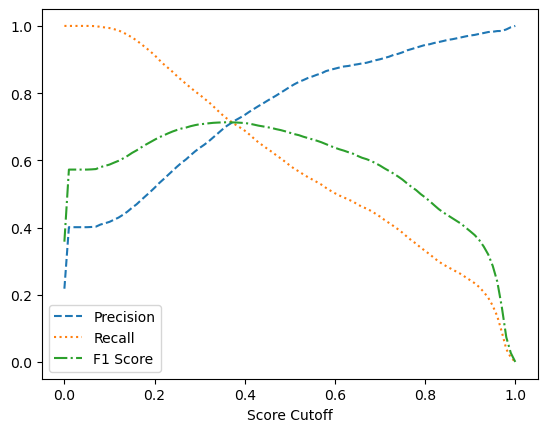

In [ ]:
best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']
best_cut_original = best_cut

fig, ax = plt.subplots()
ax.plot(model_metrics['cutoff'], model_metrics['precision'], label='Precision',linestyle='--')
ax.plot(model_metrics['cutoff'], model_metrics['recall'], label='Recall',linestyle=':')
ax.plot(model_metrics['cutoff'], model_metrics['f1'], label='F1 Score',linestyle='-.')
ax.legend(loc=3)
ax.set_xlabel('Score Cutoff')


In [ ]:
# This function generates a confusion matrix from actual and predicted values, allowing for slicing by a variable and level, with a specified cutoff threshold.

def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5):
    """
    Creates confusion matrix from pandas dataframe of y and yhat values, can be sliced by a variable and level.

    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        by: By variable to slice frame before creating confusion matrix, default None.
        level: Value of by variable to slice frame before creating confusion matrix, default None.
        cutoff: Cutoff threshold for confusion matrix, default 0.5.

    Returns:
        Confusion matrix as pandas dataframe.
    """

    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True)

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list],
                            index=['predicted: ' + str(i) for i in level_list])

    # don't destroy original data
    frame_ = frame.copy(deep=True)

    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)

    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]

    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]

    return cm_frame

get_confusion_matrix(test, target, f'p_{target}', cutoff=best_cut)

,actual: 1,actual: 0
predicted: 1,26875,11439
predicted: 0,10325,123783


### Confusion Matrix Disparity Metrics

In [ ]:
metric_dict = {
'Prevalence': '(tp + fn) / (tp + tn +fp + fn)', # how much default actually happens for this group
'Accuracy': '(tp + tn) / (tp + tn + fp + fn)', # how often the model predicts default and non-default correctly for this group
'True Positive Rate': 'tp / (tp + fn)',  # out of the people in the group *that did* default, how many the model predicted *correctly* would default
'Precision': 'tp / (tp + fp)',  # out of the people in the group the model *predicted* would default, how many the model predicted *correctly* would default
'Specificity': 'tn / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *correctly* would not default
'Negative Predicted Value': 'tn / (tn + fn)', # out of the people in the group the model *predicted* would not default, how many the model predicted *correctly* would not default

'False Positive Rate': 'fp / (tn + fp)', # out of the people in the group *that did not* default, how many the model predicted *incorrectly* would default
'False Discovery Rate': 'fp / (tp + fp)', # out of the people in the group the model *predicted* would default, how many the model predicted *incorrectly* would default

'False Negative Rate': 'fn / (tp + fn)', # out of the people in the group *that did* default, how many the model predicted *incorrectly* would not default
'False Omissions Rate': 'fn / (tn + fn)'  # out of the people in the group the model *predicted* would not default, how many the model predicted *incorrectly* would not default
}


def confusion_matrix_parser(expression):

    # tp | fp       cm_dict[level].iat[0, 0] | cm_dict[level].iat[0, 1]
    # -------  ==>  --------------------------------------------
    # fn | tn       cm_dict[level].iat[1, 0] | cm_dict[level].iat[1, 1]

    expression = expression.replace('tp', 'cm_dict[level].iat[0, 0]')\
                           .replace('fp', 'cm_dict[level].iat[0, 1]')\
                           .replace('fn', 'cm_dict[level].iat[1, 0]')\
                           .replace('tn', 'cm_dict[level].iat[1, 1]')

    return expression

In [ ]:
data['derived_sex'].unique()

array(['Female', 'Male', 'Joint', 'Sex Not Available'], dtype=object)

In [ ]:
# initialize dict of confusion matrices and corresponding rows of dataframe

# Adjusted code for confusion matrices
sex_confusion_mats = {
    'Male': get_confusion_matrix(test, target, f'p_{target}', by='derived_sex', level='Male', cutoff=best_cut),
    'Female': get_confusion_matrix(test, target, f'p_{target}', by='derived_sex', level='Female', cutoff=best_cut),
    'Joint': get_confusion_matrix(test, target, f'p_{target}', by='derived_sex', level='Joint', cutoff=best_cut),
    'Sex Not Available': get_confusion_matrix(test, target, f'p_{target}', by='derived_sex', level='Sex Not Available', cutoff=best_cut)
}


def confusion_matrix_metrics(cm_dict, metric_dict):
    levels = list(cm_dict.keys())

    metrics_frame = pd.DataFrame(index=levels) # frame for metrics

    for level in levels:
        for metric in metric_dict.keys():

            # parse metric expressions into executable pandas statements
            expression = confusion_matrix_parser(metric_dict[metric])

            # dynamically evaluate metrics to avoid code duplication
            metrics_frame.loc[level, metric] = eval(expression)

    return metrics_frame

sex_confusion_metrics = confusion_matrix_metrics(sex_confusion_mats, metric_dict)

### **Sex confusion metrics**

In [ ]:
sex_confusion_metrics

,Prevalence,Accuracy,True Positive Rate,Precision,Specificity,Negative Predicted Value,False Positive Rate,False Discovery Rate,False Negative Rate,False Omissions Rate
Male,0.238463,0.867837,0.724370,0.722226,0.912762,0.913611,0.087238,0.277774,0.275630,0.086389
Female,0.257789,0.864041,0.772307,0.720423,0.895902,0.918887,0.104098,0.279577,0.227693,0.081113
Joint,0.158062,0.885597,0.666496,0.630687,0.926730,0.936715,0.073270,0.369313,0.333504,0.063285
Sex Not Available,0.260596,0.873216,0.727809,0.772510,0.924463,0.905986,0.075537,0.227490,0.272191,0.094014


In [ ]:
data['derived_race'].unique()

array(['White', 'Race Not Available', 'Black or African American',
       'Asian', 'Native Hawaiian or Other Pacific Islander', 'Joint',
       'American Indian or Alaska Native', '2 or more minority races'],
      dtype=object)

In [ ]:
race_levels = ['White', 'Race Not Available', 'Black or African American',
       'Asian', 'Native Hawaiian or Other Pacific Islander', 'Joint',
       'American Indian or Alaska Native', '2 or more minority races']

In [ ]:

# Adjusted code for confusion matrices
race_confusion_mats = {
    'White': get_confusion_matrix(test, target, f'p_{target}', by='derived_race', level='White', cutoff=best_cut),
    'Race Not Available': get_confusion_matrix(test, target, f'p_{target}', by='derived_race', level='Race Not Available', cutoff=best_cut),
    'Black or African American': get_confusion_matrix(test, target, f'p_{target}', by='derived_race', level='Black or African American', cutoff=best_cut),
    'Asian': get_confusion_matrix(test, target, f'p_{target}', by='derived_race', level='Asian', cutoff=best_cut),
    'Native Hawaiian or Other Pacific Islander': get_confusion_matrix(test, target, f'p_{target}', by='derived_race', level='Native Hawaiian or Other Pacific Islander', cutoff=best_cut),
    'Joint': get_confusion_matrix(test, target, f'p_{target}', by='derived_race', level='Joint', cutoff=best_cut),
    'American Indian or Alaska Native': get_confusion_matrix(test, target, f'p_{target}', by='derived_race', level='American Indian or Alaska Native', cutoff=best_cut),
    '2 or more minority races': get_confusion_matrix(test, target, f'p_{target}', by='derived_race', level='2 or more minority races', cutoff=best_cut)
}




def confusion_matrix_metrics(cm_dict, metric_dict):
    levels = list(cm_dict.keys())

    metrics_frame = pd.DataFrame(index=levels) # frame for metrics

    for level in levels:
        for metric in metric_dict.keys():

            # parse metric expressions into executable pandas statements
            expression = confusion_matrix_parser(metric_dict[metric])

            # dynamically evaluate metrics to avoid code duplication
            metrics_frame.loc[level, metric] = eval(expression)

    return metrics_frame

race_confusion_metrics = confusion_matrix_metrics(race_confusion_mats, metric_dict)

### **Race confusion metrics**

In [ ]:
race_confusion_metrics

,Prevalence,Accuracy,True Positive Rate,Precision,Specificity,Negative Predicted Value,False Positive Rate,False Discovery Rate,False Negative Rate,False Omissions Rate
White,0.191330,0.874560,0.713701,0.658990,0.912619,0.930905,0.087381,0.341010,0.286299,0.069095
Race Not Available,0.255175,0.870641,0.726660,0.756730,0.919968,0.907612,0.080032,0.243270,0.273340,0.092388
Black or African American,0.337869,0.854528,0.787212,0.783309,0.888877,0.891143,0.111123,0.216691,0.212788,0.108857
Asian,0.198575,0.895202,0.630144,0.799636,0.960877,0.912931,0.039123,0.200364,0.369856,0.087069
Native Hawaiian or Other Pacific Islander,0.356659,0.860045,0.797468,0.807692,0.894737,0.888502,0.105263,0.192308,0.202532,0.111498
Joint,0.171421,0.891550,0.711146,0.674107,0.928873,0.939553,0.071127,0.325893,0.288854,0.060447
American Indian or Alaska Native,0.352195,0.865366,0.800554,0.814085,0.900602,0.892537,0.099398,0.185915,0.199446,0.107463
2 or more minority races,0.349741,0.867876,0.777778,0.833333,0.916335,0.884615,0.083665,0.166667,0.222222,0.115385



$$\text{False Omissions Rate} = \frac{\text{False Negatives}}{\text{Actual Negatives}} = \frac{\text{False Negatives}}{\text{False Negatives} + \text{True Negatives}}$$

Where:
- False Negatives: Instances where the model incorrectly predicts loan denial (1) when the actual outcome is loan approval (0).
- Actual Negatives: Instances where the actual outcome is loan approval (0), regardless of the model's prediction.

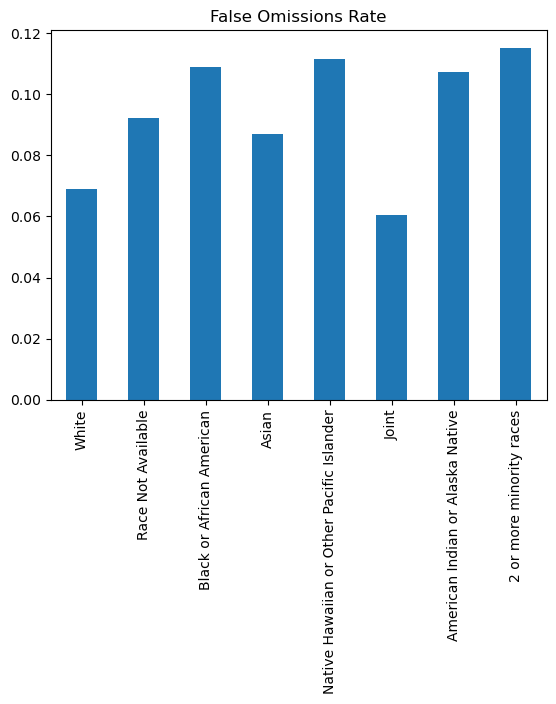

In [ ]:
_ = race_confusion_metrics['False Omissions Rate'].plot(kind='bar', title='False Omissions Rate')

In [ ]:
race_disparity_frame = race_confusion_metrics/race_confusion_metrics.loc['White', :]
race_disparity_frame.columns=[col + ' Disparity' for col in race_confusion_metrics.columns]

# small utility function to format pandas table output
def disparate_red(val, parity_threshold_low=0.8, parity_threshold_hi=1.25):
    color = 'grey' if (parity_threshold_low < val < parity_threshold_hi) else 'red'
    return 'color: %s' % color

race_disparity_frame.style.applymap(disparate_red)

,Prevalence Disparity,Accuracy Disparity,True Positive Rate Disparity,Precision Disparity,Specificity Disparity,Negative Predicted Value Disparity,False Positive Rate Disparity,False Discovery Rate Disparity,False Negative Rate Disparity,False Omissions Rate Disparity
White,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Race Not Available,1.333689,0.995519,1.018158,1.148318,1.008053,0.974979,0.915896,0.713381,0.954734,1.337105
Black or African American,1.765894,0.977095,1.103000,1.188652,0.973985,0.957287,1.271703,0.635437,0.743236,1.575464
Asian,1.037864,1.023603,0.882924,1.213427,1.052879,0.980692,0.447725,0.587561,1.291852,1.260130
Native Hawaiian or Other Pacific Islander,1.864102,0.983404,1.117371,1.225653,0.980406,0.954450,1.204643,0.563935,0.707412,1.613687
Joint,0.895942,1.019427,0.996421,1.022941,1.017810,1.009291,0.813985,0.955668,1.008923,0.874831
American Indian or Alaska Native,1.840770,0.989487,1.121694,1.235353,0.986833,0.958785,1.137517,0.545190,0.696634,1.555281
2 or more minority races,1.827943,0.992357,1.089782,1.264562,1.004072,0.950275,0.957476,0.488744,0.776188,1.669933


### **Exampel:**

- **Prevalence Disparity:**
  - White People: 1
  - Black People: 1.765894
  - *Interpretation:* The prevalence of loan denial among black applicants is approximately 1.765894 times higher than among white applicants.

- **False Positive Rate Disparity:**
  - White People: 1
  - Black People: 1.271703
  - *Interpretation:* The false positive rate among black applicants is 1.271703 times higher than among white applicants.

- **False Discovery Rate Disparity:**
  - White People: 1
  - Black People: 0.635437
  - *Interpretation:* The false discovery rate among black applicants is 0.635437 times lower than among white applicants.

- **False Negative Rate Disparity:**
  - White People: 1
  - Black People: 0.743236
  - *Interpretation:* The false negative rate among black applicants is 0.743236 times lower than among white applicants.

- **False Omissions Rate Disparity:**
  - White People: 1
  - Black People: 1.575464
  - *Interpretation:* The false omissions rate among black applicants is 1.575464 times higher than among white applicants.


In [ ]:
sex_disparity_frame = sex_confusion_metrics/sex_confusion_metrics.loc['Male', :]
sex_disparity_frame.columns=[col + ' Disparity' for col in sex_confusion_metrics.columns]

# small utility function to format pandas table output
def disparate_red(val, parity_threshold_low=0.8, parity_threshold_hi=1.25):
    color = 'grey' if (parity_threshold_low < val < parity_threshold_hi) else 'red'
    return 'color: %s' % color

sex_disparity_frame.style.applymap(disparate_red)

,Prevalence Disparity,Accuracy Disparity,True Positive Rate Disparity,Precision Disparity,Specificity Disparity,Negative Predicted Value Disparity,False Positive Rate Disparity,False Discovery Rate Disparity,False Negative Rate Disparity,False Omissions Rate Disparity
Male,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Female,1.081045,0.995625,1.066177,0.997503,0.981530,1.005775,1.193254,1.006491,0.826083,0.938921
Joint,0.662835,1.020465,0.920104,0.873255,1.015304,1.025289,0.839877,1.329545,1.209970,0.732557
Sex Not Available,1.092816,1.006198,1.004747,1.069624,1.012820,0.991654,0.865869,0.818974,0.987524,1.088258


### Fair Lending Disparity Analysis

In [ ]:
#This code calculates fair lending disparity metrics, including Adverse Impact Ratio (AIR) and Standardized Mean Difference (SMD),
to assess potential discriminatory outcomes in lending practices based on demographic groups.

from scipy.stats import ttest_ind, chisquare, fisher_exact, chi2_contingency


def air_statistical_signif(group_count, group_favorable, reference_count, reference_favorable):
    # Perform a chi-square test
    # (or Fisher's exact when cells in the contingency test have less than 30 individuals in them).

    group_unfavorable = group_count - group_favorable
    reference_unfavorable = reference_count - reference_favorable

    contingency_table = np.array([[group_favorable, group_unfavorable],
                                  [reference_favorable, reference_unfavorable]])

    if np.min(contingency_table) < 30:
        _, p = fisher_exact(contingency_table)
    else:
        _, p, _, _ = chi2_contingency(contingency_table)

    return p

def smd_statistical_signif(group_scores, reference_scores):
    # Perform a one-sided t-test. An outcome of 1 is assumed to be favorable.

    # We do not assume that the two scores have equal variance. Furthermore, we are testing
    # against the alternative hypothesis that the group receives lower scores than the reference
    # group.
    _, p = ttest_ind(group_scores, reference_scores, equal_var=False, alternative='less')
    return p


def fair_lending_disparity(frame, y, yhat, demo_name, groups, reference_group, cutoff=0.5, favorable_outcome=0):
    """
    Creates a table of fair lending disparity metrics (AIR and SMD).

    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values with group membership.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        demo_name: The name of the column containing the group information
        groups: The names of the groups in the demo_name column.
        reference_group: The control group.
        cutoff: Cutoff threshold for confusion matrix, default 0.5.
        favorable_outcome: The value {0, 1} that corresponds to a desirable outcome.

    Returns:
        A DataFrame summarizing the fair lending metrics analysis
    """

    protected_groups = [group for group in groups if group != reference_group]
    groups_ordered = protected_groups + [reference_group]

    temp_frame = frame.copy()
    temp_frame['model_outcome'] = np.where(temp_frame[yhat] <= cutoff, 0, 1)
    temp_frame['fav_outcome'] = temp_frame['model_outcome'] == favorable_outcome
    temp_frame['fav_score'] = temp_frame[yhat] if favorable_outcome else 1-temp_frame[yhat]

    disparity_table = pd.DataFrame(index=groups_ordered)

    disparity_table['Count'] = [len(temp_frame.loc[temp_frame[demo_name] == group]) for group in groups_ordered]
    disparity_table['Favorable Outcomes'] = [temp_frame.loc[temp_frame[demo_name] == group]['fav_outcome'].sum()
                                             for group in groups_ordered]
    disparity_table['Favorable Rate'] = [disparity_table['Favorable Outcomes'][group]/disparity_table['Count'][group]
                                         for group in groups_ordered]
    disparity_table['Mean Score'] = [temp_frame.loc[temp_frame[demo_name] == group][yhat].mean()
                                             for group in groups_ordered]
    disparity_table['Std Score'] = [temp_frame.loc[temp_frame[demo_name].isin([reference_group, group])][yhat].std()
                                             for group in groups_ordered]
    try:
        disparity_table['AIR'] = [disparity_table['Favorable Rate'][group]/disparity_table['Favorable Rate'][reference_group]
                                  for group in groups_ordered]
    except:
        disparity_table['AIR'] = np.nan

    disparity_table['AIR p-value'] = [air_statistical_signif(disparity_table['Count'][group],
                                                             disparity_table['Favorable Outcomes'][group],
                                                             disparity_table['Count'][reference_group],
                                                             disparity_table['Favorable Outcomes'][reference_group])
                                      for group in groups_ordered]

    disparity_table['SMD'] = [(disparity_table['Mean Score'][group] -
                               disparity_table['Mean Score'][reference_group]) /
                              disparity_table['Std Score'][group]
                              for group in groups_ordered]

    disparity_table['SMD p-value'] = [smd_statistical_signif(temp_frame.loc[temp_frame[demo_name] == group]['fav_score'],
                                                             temp_frame.loc[temp_frame[demo_name] == reference_group]['fav_score'])
                                      for group in groups_ordered]

    return disparity_table


Adverse Impact Ratio (AIR):
$$ \text{AIR} = \frac{\text{Favorable Rate}_{\text{ Protect Group}}}{\text{Favorable Rate}_{\text{Reference Group}}} $$

Standardized Mean Difference (SMD):
$$ \text{SMD} = \frac{\text{Mean Score}_{\text{Protect Group}} - \text{Mean Score}_{\text{Reference Group}}}{\text{Standard Deviation}_{\text{Group}}} $$


### Fair_lending(Training)

In [ ]:
fair_lending_disparity(train, y=target, yhat=f'p_{target}',
                       demo_name='derived_race', groups=race_levels, reference_group='White',
                       cutoff=best_cut)

,Count,Favorable Outcomes,Favorable Rate,Mean Score,Std Score,AIR,AIR p-value,SMD,SMD p-value
Race Not Available,114547,86070,0.751395,0.229682,0.276803,0.947593,4.141329e-205,0.084158,8.097111e-128
Black or African American,56978,37475,0.657710,0.288283,0.280104,0.829446,0.000000e+00,0.292380,0.000000e+00
Asian,41566,34855,0.838546,0.183237,0.270734,1.057500,2.966814e-108,-0.085505,1.000000e+00
Native Hawaiian or Other Pacific Islander,1697,1203,0.708898,0.274452,0.271520,0.894000,1.983915e-17,0.250683,5.046228e-18
Joint,14727,12206,0.828818,0.178278,0.270942,1.045232,3.585033e-26,-0.103745,1.000000e+00
American Indian or Alaska Native,4298,2738,0.637040,0.309733,0.272055,0.803379,3.421369e-138,0.379874,3.857605e-83
2 or more minority races,1484,961,0.647574,0.314785,0.271598,0.816663,4.743990e-43,0.399114,2.427766e-32
White,453067,359260,0.792951,0.206386,0.271326,1.000000,1.000000e+00,0.000000,5.000000e-01


### Fair_lending(Validing)

In [ ]:
fair_lending_disparity(valid, y=target, yhat=f'p_{target}',
                       demo_name='derived_race', groups=race_levels, reference_group='White',
                       cutoff=best_cut)

,Count,Favorable Outcomes,Favorable Rate,Mean Score,Std Score,AIR,AIR p-value,SMD,SMD p-value
Race Not Available,28616,21421,0.748567,0.231941,0.277530,0.944639,3.131401e-58,0.091367,4.307842e-39
Black or African American,14211,9270,0.652312,0.292607,0.280515,0.823171,0.000000e+00,0.306661,1.126069e-186
Asian,10232,8539,0.834539,0.186536,0.271425,1.053129,5.216368e-24,-0.073860,1.000000e+00
Native Hawaiian or Other Pacific Islander,427,281,0.658080,0.312426,0.271912,0.830450,1.315355e-11,0.389253,6.832518e-10
Joint,3688,3038,0.823753,0.182156,0.271080,1.039518,4.186220e-06,-0.090113,1.000000e+00
American Indian or Alaska Native,1104,721,0.653080,0.291228,0.272215,0.824141,1.351553e-29,0.310946,4.557881e-17
2 or more minority races,370,234,0.632432,0.324555,0.271839,0.798085,6.129630e-14,0.433974,9.488578e-11
White,112867,89440,0.792437,0.206584,0.271351,1.000000,1.000000e+00,0.000000,5.000000e-01


### Fair_lending(Testing)

In [ ]:
fair_lending_disparity(test, y=target, yhat=f'p_{target}',
                       demo_name='derived_race', groups=race_levels, reference_group='White',
                       cutoff=best_cut)

,Count,Favorable Outcomes,Favorable Rate,Mean Score,Std Score,AIR,AIR p-value,SMD,SMD p-value
Race Not Available,28502,21518,0.754965,0.227307,0.277556,0.952294,7.037889e-44,0.073304,5.034905e-26
Black or African American,14257,9416,0.660447,0.288099,0.280402,0.833073,3.864572e-281,0.289360,2.490601e-170
Asian,10525,8878,0.843515,0.181482,0.271595,1.063990,3.917238e-35,-0.093815,1.000000e+00
Native Hawaiian or Other Pacific Islander,443,287,0.647856,0.326521,0.272542,0.817190,9.674048e-14,0.438686,1.065348e-12
Joint,3716,3044,0.819160,0.187054,0.271720,1.033269,1.007523e-04,-0.073264,9.999977e-01
American Indian or Alaska Native,1025,670,0.653659,0.302185,0.272892,0.824509,1.473627e-27,0.348941,1.861258e-18
2 or more minority races,386,260,0.673575,0.294575,0.272418,0.849632,1.185918e-08,0.321615,1.986591e-07
White,113568,90035,0.792785,0.206961,0.272146,1.000000,1.000000e+00,0.000000,5.000000e-01


### Individual Fairness Analysis

**Note:**

**The following code provides a deeper understanding of individual fairness analysis.**

**If you are more concerned about the debiasing method and results, you can ignore the part I changed to markdown.**

**However, you may still have to run the version of the code that I've kept since some of it is related to the debiasing code.**

**The code may take a while, so please be patient.**

In [ ]:
#The code generates a plot of log loss residuals for individuals who were misclassified as having received an unfavorable outcome,
#across different groups specified in the dataset.

def plot_group_residuals(frame, y, yhat, demo_name, groups, cutoff=0.5, favorable_outcome=0):
    """
    Generates a plot of logloss residuals for individuals who falsely received an unfavorable outcome.

    Args:
        frame: Pandas dataframe of actual (y) and predicted (yhat) values with group membership.
        y: Name of actual value column.
        yhat: Name of predicted value column.
        demo_name: The name of the column containing the group information
        groups: The names of the groups in the demo_name column.
        cutoff: Cutoff threshold for confusion matrix, default 0.5.
        favorable_outcome: The value {0, 1} that corresponds to a desirable outcome.

    Returns:
        Axes of the plot
    """

    fig, axs = plt.subplots(1, len(groups), figsize=(5*len(groups), 5))
    for i, group in enumerate(groups):
        group_frame = frame.loc[frame[demo_name] == group].copy()
        group_frame[f'{yhat}_outcome'] = np.where(group_frame[yhat] > cutoff, 1, 0)

        group_frame[f'{y}_residual'] = -group_frame[y]*np.log(group_frame[yhat])
        group_frame[f'{y}_residual'] -= (1 - group_frame[y])*np.log(1 - group_frame[yhat])

        misclassified_obs = group_frame[(group_frame[y] == favorable_outcome) &
                                        (group_frame[f'{yhat}_outcome'] == (1 - favorable_outcome))]
        axs[i].scatter(misclassified_obs[yhat], misclassified_obs[f'{y}_residual'], marker='o', alpha=0.3)
        axs[i].set_xlabel('Score')
        axs[i].set_ylabel('Residual')
        axs[i].set_title(group)
        axs[i].set_xlim([0, 1])
        axs[i].set_ylim([0, 2])

    fig.suptitle('Logloss Residuals')

    return axs

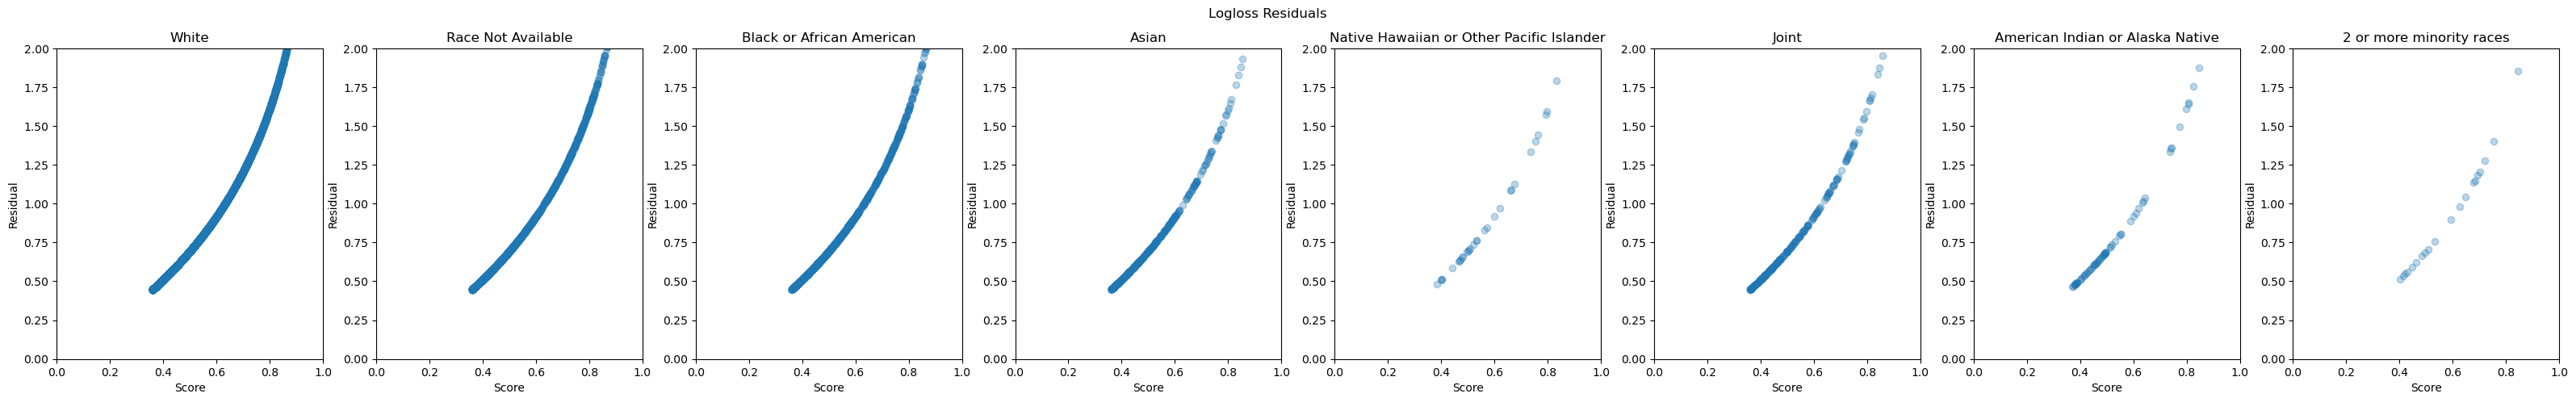

In [ ]:
_ = plot_group_residuals(test, y=target, yhat=f'p_{target}',
                       demo_name='derived_race', groups=race_levels,
                       cutoff=best_cut)


In [ ]:
# Examine outlying misclassified black observations

black_obs = valid.loc[valid['derived_race'] == 'Black or African American'].copy()
black_obs[f'p_{target}_outcome'] = np.where(black_obs[f'p_{target}'] > best_cut, 1, 0)

misclassified_obs = black_obs[(black_obs[target] == 0) &
                              (black_obs[f'p_{target}_outcome'] == 1)]

misclassified_obs.sort_values(by=f'p_{target}').head(3)[features]

,loan_amount,combined_loan_to_value_ratio,property_value,income,derived_loan_product_type_Conventional:First Lien,derived_loan_product_type_Conventional:Subordinate Lien,derived_loan_product_type_FHA:First Lien,derived_loan_product_type_VA:First Lien,derived_dwelling_category_Single Family (1-4 Units):Manufactured,derived_dwelling_category_Single Family (1-4 Units):Site-Built,...,debt_to_income_ratio_44,debt_to_income_ratio_45,debt_to_income_ratio_46,debt_to_income_ratio_47,debt_to_income_ratio_48,debt_to_income_ratio_49,debt_to_income_ratio_50%-60%,debt_to_income_ratio_less20%,debt_to_income_ratio_above60%,debt_to_income_ratio_Exempt
1010772,0.016824,-0.001921,0.013307,0.000708,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
728176,-0.776353,-0.000501,-0.040596,-0.012606,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
742407,-0.600091,-0.000763,-0.036104,-0.008445,0,1,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
# We'll train an adversarial model that attempts to predict each observations' race/ethnicity (black/Native Hawaiian/American Indian
#  or asian/white). Compare an adversary that doesn't have access to the model's predictions with one
#  that does. If the model predictions meaningfully improve the performance of the adversary for certain
#  observations, there is a potential individual fairness concern.

train['protected'] = np.where((train['derived_race'] == 'Black or African American') |
                              (train['derived_race'] == 'Native Hawaiian or Other Pacific Islander') |
                              (train['derived_race'] == 'American Indian or Alaska Native') |
                              (train['derived_race'] == '2 or more minority races'), 1, 0)

valid['protected'] = np.where((valid['derived_race'] == 'Black or African American')
                              | (valid['derived_race'] == 'Native Hawaiian or Other Pacific Islander') |
                              (valid['derived_race'] == 'American Indian or Alaska Native') |
                              (valid['derived_race'] == '2 or more minority races'), 1, 0)

dtrain_adversary = xgb.DMatrix(train[features],
                     label=train['protected'])

dvalid_adversary = xgb.DMatrix(valid[features],
                     label=valid['protected'])

base_score_adversary = train['protected'].mean()

params_adversary = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.05,
    'subsample': 0.75,
    'colsample_bytree': 0.8,
    'max_depth': 5,
    'base_score': base_score_adversary,
    'seed': seed
}

# Train using early stopping on the validation dataset.
watchlist_adversary = [(dtrain_adversary, 'train'), (dvalid_adversary, 'eval')]

adversary_model = xgb.train(params,
                              dtrain_adversary,
                              num_boost_round=200,
                              evals=watchlist_adversary,
                              early_stopping_rounds=10,
                              verbose_eval=False)

In [ ]:
dtrain_adversary_ii = xgb.DMatrix(train[features + [f'p_{target}']],
                     label=train['protected'])

dvalid_adversary_ii = xgb.DMatrix(valid[features + [f'p_{target}']],
                     label=valid['protected'])

watchlist_adversary_ii = [(dtrain_adversary_ii, 'train'), (dvalid_adversary_ii, 'eval')]

adversary_model_ii = xgb.train(params,
                              dtrain_adversary_ii,
                              num_boost_round=200,
                              evals=watchlist_adversary_ii,
                              early_stopping_rounds=10,
                              verbose_eval=False)

In [ ]:
adversarial_outputs = pd.DataFrame({'protected': valid['protected'],
                                    'P(protected) (1)': adversary_model.predict(dvalid_adversary),
                                    'P(protected) (2)': adversary_model_ii.predict(dvalid_adversary_ii)})

In [ ]:
adversarial_outputs['delta'] = adversarial_outputs['P(protected) (2)'] - adversarial_outputs['P(protected) (1)']
adversarial_outputs.loc[adversarial_outputs['protected'] == 1].sort_values('delta', ascending=False)

,protected,P(protected) (1),P(protected) (2),delta
402853,1,0.224430,0.302092,0.077662
586689,1,0.540254,0.617186,0.076932
54193,1,0.120820,0.197172,0.076352
867548,1,0.202372,0.275354,0.072982
128831,1,0.144299,0.216739,0.072440
...,...,...,...,...
999209,1,0.376335,0.285434,-0.090901
866315,1,0.634160,0.542999,-0.091161
40875,1,0.291283,0.194298,-0.096985
392484,1,0.389055,0.262577,-0.126478


In [ ]:
most_affected_obs = adversarial_outputs.sort_values('delta', ascending=False).index[:5]
most_affected_obs

Int64Index([557150, 927668, 479332, 199311, 719906], dtype='int64')

In [ ]:
valid.loc[24497]

lei                                549300W4FT4H1UWPGU95
derived_ethnicity                Not Hispanic or Latino
derived_race                                      Asian
derived_sex                                       Joint
loan_amount                                   -0.394453
                                          ...          
debt_to_income_ratio_above60%                         0
debt_to_income_ratio_Exempt                           0
action_taken_encoded                                  0
p_action_taken_encoded                         0.201878
protected                                             0
Name: 24497, Length: 66, dtype: object

In [ ]:
explanation_data = valid[features + [f'p_{target}']]

adversarial_shap_values = shap.TreeExplainer(adversary_model_ii).shap_values(explanation_data)

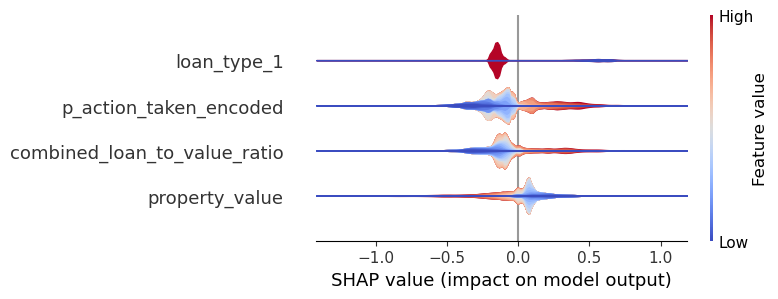

In [ ]:
# Observe that higher model scores result in a positive contribution to the protected group prediction, however
# the relationship is nonlinear (the color gradient for p_action_taken_encoded does not smoothly move from cool to hot).
# This suggests there are feature interactions with p_action_taken_encoded that are contributing towards the adversarial
# model prediction - these are interactions to investigate for proxy effects.

shap.summary_plot(adversarial_shap_values,
                  explanation_data,
                  plot_type="layered_violin",
                  color='coolwarm', max_display=4, show=False)

fig = plt.gcf()
#fig.savefig('../Data/Data/Figures/shap_summary_violin.png', bbox_inches='tight')

(-0.6927179992198944, 0.8050428330898285)

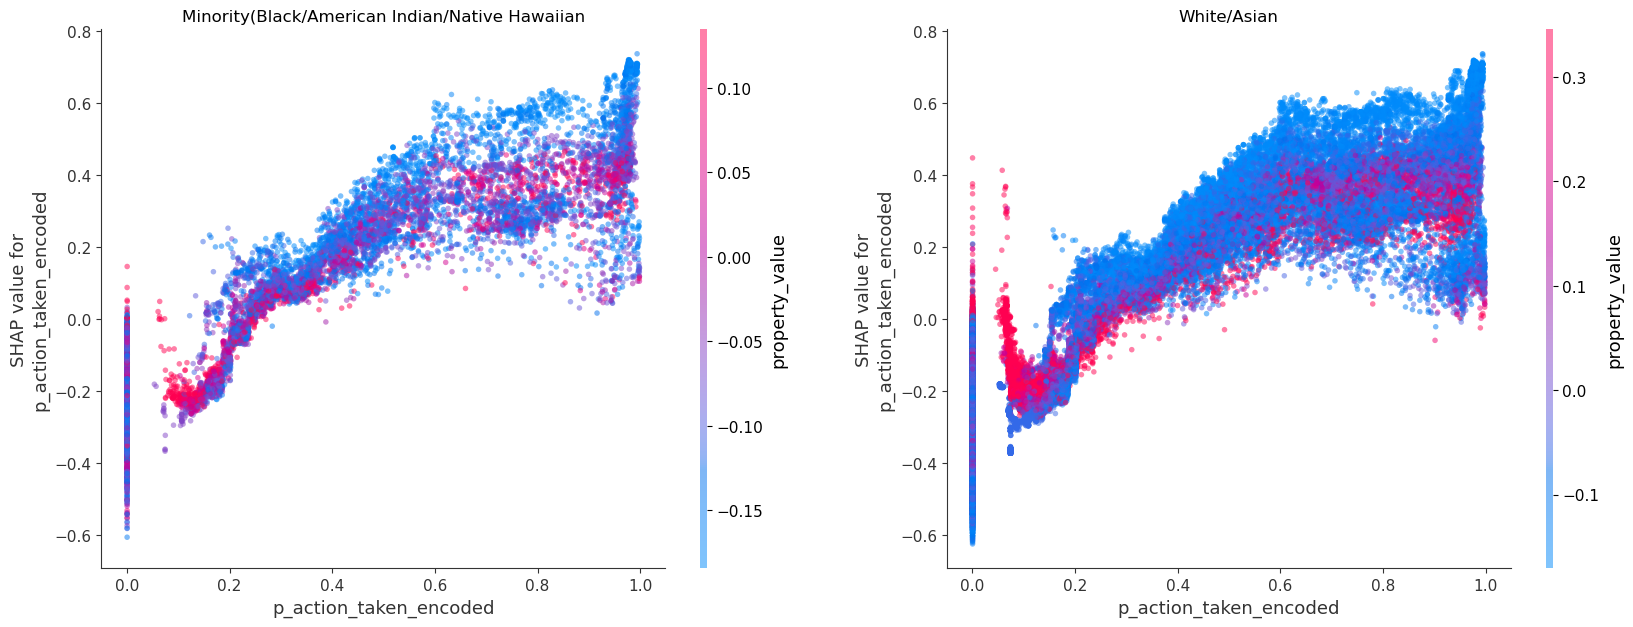

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 7))

shap.dependence_plot('p_action_taken_encoded',
                     adversarial_shap_values[valid['protected'] == 1],
                     explanation_data.loc[valid['protected'] == 1],
                     interaction_index='property_value',
                     alpha=0.5,
                     ax=ax0,
                     show=False)

ax0.set_title('Minority(Black/American Indian/Native Hawaiian')

shap.dependence_plot('p_action_taken_encoded',
                     adversarial_shap_values[valid['protected'] == 0],
                     explanation_data.loc[valid['protected'] == 0],
                     interaction_index='property_value',
                     alpha=0.5,
                     ax=ax1,
                     show=False)

ax1.set_title('White/Asian')

ylim = (np.min([ax0.get_ylim()[0], ax1.get_ylim()[0]]),
        np.max([ax0.get_ylim()[1], ax1.get_ylim()[1]]))

ax0.set_ylim(ylim)
ax1.set_ylim(ylim)

(-0.6927179992198944, 0.8050428330898285)

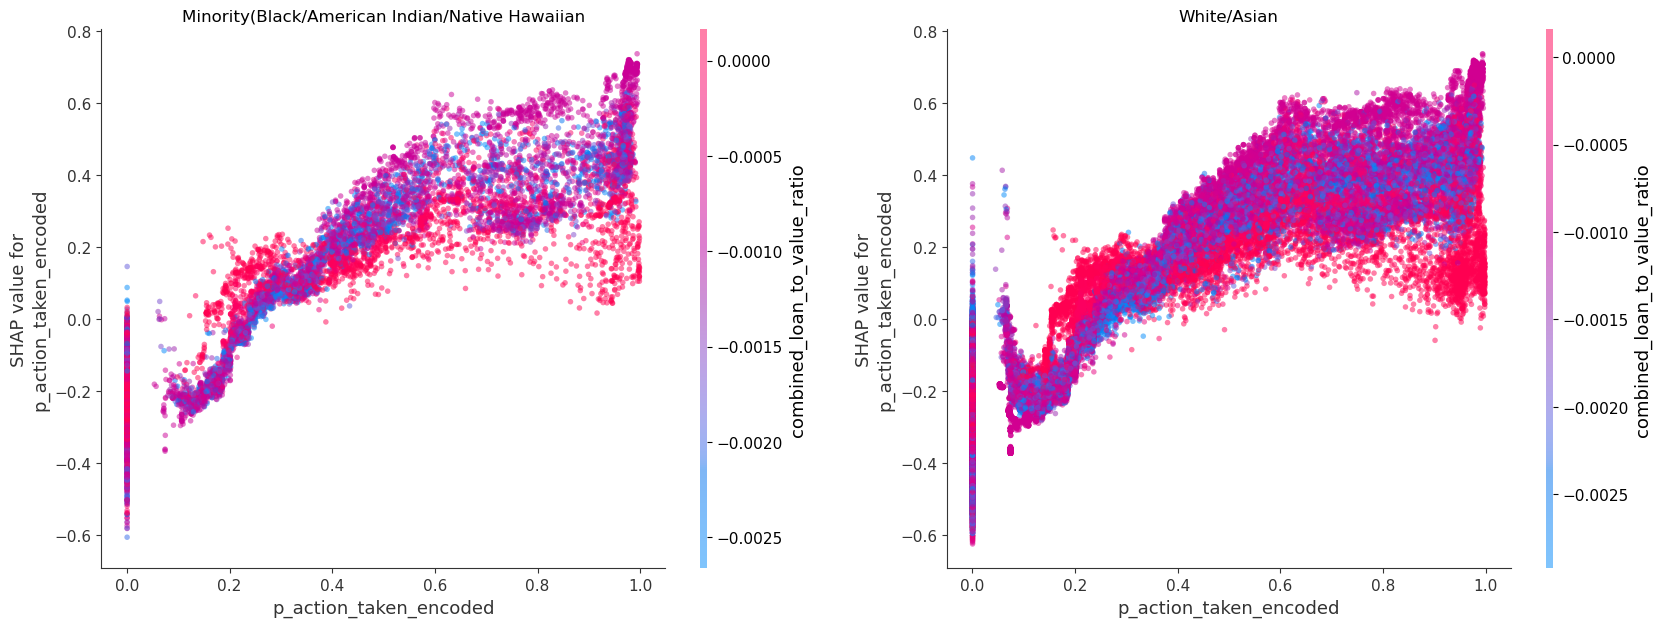

In [ ]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 7))

shap.dependence_plot('p_action_taken_encoded',
                     adversarial_shap_values[valid['protected'] == 1],
                     explanation_data.loc[valid['protected'] == 1],
                     interaction_index='combined_loan_to_value_ratio',
                     alpha=0.5,
                     ax=ax0,
                     show=False)

ax0.set_title('Minority(Black/American Indian/Native Hawaiian')

shap.dependence_plot('p_action_taken_encoded',
                     adversarial_shap_values[valid['protected'] == 0],
                     explanation_data.loc[valid['protected'] == 0],
                     interaction_index='combined_loan_to_value_ratio',
                     alpha=0.5,
                     ax=ax1,
                     show=False)

ax1.set_title('White/Asian')

ylim = (np.min([ax0.get_ylim()[0], ax1.get_ylim()[0]]),
        np.max([ax0.get_ylim()[1], ax1.get_ylim()[1]]))

ax0.set_ylim(ylim)
ax1.set_ylim(ylim)

**Note:**

**The following code provides more details on SHAP value analysis.**


**This code will probably take you 2-3 hours, so I changed it to markdown to prevent someone from accidentally running it.**


**This code does not affect the results, but people who are still interested in the content can turn to the code and run it.**

In [ ]:
#don't run them  it too more than 1 hour

In [ ]:
#don't run them  it too more than 1 hour

In [ ]:
#don't run them  it too more than 1 hour

In [ ]:
#don't run them  it too more than 1 hour

In [ ]:
#don't run them  it too more than 1 hour

In [ ]:
#don't run them  it too more than 1 hour

In [ ]:
#don't run them  it too more than 1 hour

In [ ]:
#don't run them  it too more than 1 hour

In [ ]:
#don't run them  it too more than 1 hour

# Calculate interaction values for the top 100 observations that had their predictions change the most
#  from adversary i to adversary ii.

explainer = shap.TreeExplainer(adversary_model_ii)
expected_value = explainer.expected_value[0]

explanation_data = valid[features + [f'p_{target}']] #  .loc[most_affected_obs]

shap_values = explainer.shap_values(explanation_data)
shap_interaction_values = explainer.shap_interaction_values(explanation_data)

# shap.decision_plot(expected_value, shap_interaction_values, feature_names=features + [f'p_{target}'], link='logit',
#                   ignore_warnings=True, alpha=0.3)

shap.decision_plot(expected_value, shap_interaction_values, feature_names=features + [f'p_{target}'],
                  ignore_warnings=True, alpha=0.3, feature_order='hclust')

highlight_obs = np.where(valid.index.isin(most_affected_obs), 1, 0)

shap.decision_plot(expected_value, shap_values, feature_names=features + [f'p_{target}'],
                   link='logit', ignore_warnings=True, alpha=0.3, highlight=highlight_obs)

shap.decision_plot(expected_value, shap_values,
                   feature_names=features + [f'p_{target}'],
                   feature_order='hclust',
                   ignore_warnings=True, alpha=0.3)

## 3. Remediating Model Bias

**Note:**

**The code below may take 1-2 hours to produce results.**

**Please be patient as they are important and relevant to the final result.**

### Pre-Processing

In [ ]:
def reweight_dataset(frame, y, demo_name, groups):
    """
    Generates a weight for each observation according to the reweighting algorithm of
    Kamiran and Kalders 2012, Data preprocessing techniques for classification without discrimination.

    Args:
        frame: Pandas dataframe of actual (y) and group information.
        y: Name of actual value column (assumed to be binary).
        demo_name: The name of the column containing the group information
        groups: The names of the groups in the demo_name column.

    Returns:
        A Series containing the new observation weights.
    """

    n = len(frame)

    freq_dict = {'pos': len(frame.loc[frame[y] == 1])/n,
                 'neg': len(frame.loc[frame[y] == 0])/n}

    freq_dict.update({group: frame[demo_name].value_counts()[group]/n for group in groups})

    weights = pd.Series(np.ones(n), index=frame.index)

    for label in [0, 1]:
        for group in groups:
            label_name = 'pos' if label == 1 else 'neg'
            freq = frame.loc[frame[y] == label][demo_name].value_counts()[group]/n
            weights[(frame[y] == label) & (frame[demo_name] == group)] *= freq_dict[group]*freq_dict[label_name]/freq

    return weights

### Reweigh and make deny rates the same for each game

In [ ]:
train_weights = reweight_dataset(train, target, 'derived_race', race_levels)

In [ ]:
for race in race_levels:
    print(f"Mean outcome for {race}: {np.round(train.loc[train['derived_race'] == race][target].mean(), 3)}")

    weighted_target = np.multiply(train.loc[train['derived_race'] == race][target],
                                  train_weights.loc[train['derived_race'] == race])

    print(f"Mean outcome for {race} - reweighted: {np.round(weighted_target.mean(), 3)} \n")

Mean outcome for White: 0.191
Mean outcome for White - reweighted: 0.216 

Mean outcome for Race Not Available: 0.259
Mean outcome for Race Not Available - reweighted: 0.216 

Mean outcome for Black or African American: 0.336
Mean outcome for Black or African American - reweighted: 0.216 

Mean outcome for Asian: 0.201
Mean outcome for Asian - reweighted: 0.216 

Mean outcome for Native Hawaiian or Other Pacific Islander: 0.322
Mean outcome for Native Hawaiian or Other Pacific Islander - reweighted: 0.216 

Mean outcome for Joint: 0.176
Mean outcome for Joint - reweighted: 0.216 

Mean outcome for American Indian or Alaska Native: 0.368
Mean outcome for American Indian or Alaska Native - reweighted: 0.216 

Mean outcome for 2 or more minority races: 0.376
Mean outcome for 2 or more minority races - reweighted: 0.216 



In [ ]:
dtrain = xgb.DMatrix(train[features],
                     label=train[target],
                     weight=train_weights)


model_reweighted = xgb.train(params,
                             dtrain,
                             num_boost_round=100,
                             evals=watchlist,
                             early_stopping_rounds=10,
                             verbose_eval=False)

In [ ]:
reweighted_model_metrics = perf_metrics(y_true=valid[target], y_score=model_reweighted.predict(dvalid))
reweighted_best_cut = reweighted_model_metrics.loc[reweighted_model_metrics['f1'].idxmax(), 'cutoff']

### Pre-processing (AIR)

In [ ]:
test[f'p_{target}_reweighted'] = model_reweighted.predict(xgb.DMatrix(test[features], label=test[target]))

fair_lending_disparity(test, y=target, yhat=f'p_{target}_reweighted',
                       demo_name='derived_race', groups=race_levels, reference_group='White',
                       cutoff=reweighted_best_cut)

,Count,Favorable Outcomes,Favorable Rate,Mean Score,Std Score,AIR,AIR p-value,SMD,SMD p-value
Race Not Available,28502,20930,0.734334,0.225262,0.263026,0.958607,4.363741e-29,0.064127,1.841201e-20
Black or African American,14257,9032,0.633513,0.278584,0.265572,0.826994,9.653895e-261,0.264290,1.161410e-143
Asian,10525,8736,0.830024,0.186630,0.257866,1.083521,1.737714e-50,-0.084405,1.000000e+00
Native Hawaiian or Other Pacific Islander,443,270,0.609481,0.318004,0.258540,0.795622,1.302792e-14,0.423952,4.569932e-12
Joint,3716,2968,0.798708,0.188176,0.257718,1.042641,3.914572e-06,-0.078456,9.999996e-01
American Indian or Alaska Native,1025,653,0.637073,0.294130,0.258900,0.831641,4.629408e-22,0.331148,6.209500e-17
2 or more minority races,386,251,0.650259,0.288319,0.258438,0.848854,1.151810e-07,0.309256,4.645936e-07
White,113568,86998,0.766043,0.208395,0.258199,1.000000,1.000000e+00,0.000000,5.000000e-01


In [ ]:
train[f'p_{target}_reweighted'] = model_reweighted.predict(dtrain)

fair_lending_disparity(train, y=target, yhat=f'p_{target}_reweighted',
                       demo_name='derived_race', groups=race_levels, reference_group='White',
                       cutoff=reweighted_best_cut)

,Count,Favorable Outcomes,Favorable Rate,Mean Score,Std Score,AIR,AIR p-value,SMD,SMD p-value
Race Not Available,114547,83743,0.731080,0.227397,0.262466,0.955501,1.001923e-127,0.074864,2.236612e-102
Black or African American,56978,36004,0.631893,0.278813,0.264996,0.825866,0.000000e+00,0.268176,0.000000e+00
Asian,41566,34323,0.825747,0.187819,0.256869,1.079228,7.338467e-174,-0.077581,1.000000e+00
Native Hawaiian or Other Pacific Islander,1697,1160,0.683559,0.271625,0.257628,0.893393,3.288771e-15,0.247945,1.877857e-17
Joint,14727,11909,0.808651,0.180360,0.256996,1.056884,1.208071e-34,-0.106569,1.000000e+00
American Indian or Alaska Native,4298,2637,0.613541,0.300097,0.258112,0.801881,9.882667e-120,0.357789,7.967466e-75
2 or more minority races,1484,922,0.621294,0.305322,0.257683,0.812013,1.079839e-38,0.378662,2.298690e-29
White,453067,346654,0.765127,0.207748,0.257226,1.000000,1.000000e+00,0.000000,5.000000e-01


In [ ]:
 def make_fair_objective(protected, lam):
    def fair_objective(pred, dtrain):
        """
        Fairness-aware cross-entropy loss objective function
        """
        label = dtrain.get_label()
        pred = 1.0 / (1.0 + np.exp(-pred))
        grad = (pred - label) - lam * (pred - protected)
        hess = (1 - lam) * pred * (1. - pred)

        return grad, hess
    return fair_objective

protected = np.where((train['derived_race'] == 'Black or African American') |
                              (train['derived_race'] == 'Native Hawaiian or Other Pacific Islander') |
                              (train['derived_race'] == 'American Indian or Alaska Native') |
                              (train['derived_race'] == '2 or more minority races'), 1, 0)
fair_objective = make_fair_objective(protected, lam=0.2)



In [ ]:
dtrain = xgb.DMatrix(train[features],
                     label=train[target])


# Train using early stopping on the validation dataset.
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

model_regularized = xgb.train(params,
                              dtrain,
                              num_boost_round=100,
                              evals=watchlist,
                              early_stopping_rounds=10,
                              verbose_eval=False,
                              obj=fair_objective)

### In-processing (AIR)

In [ ]:
model_metrics = perf_metrics(y_true=valid[target], y_score=model_regularized.predict(dvalid))
best_cut_regularized = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

test[f'p_{target}_regularized'] = model_regularized.predict(xgb.DMatrix(test[features], label=test[target]))

fair_lending_disparity(test, y=target, yhat=f'p_{target}_regularized',
                       demo_name='derived_race', groups=race_levels, reference_group='White',
                       cutoff=best_cut_regularized)

,Count,Favorable Outcomes,Favorable Rate,Mean Score,Std Score,AIR,AIR p-value,SMD,SMD p-value
Race Not Available,28502,21131,0.741387,0.252246,0.275784,0.963053,5.257664e-24,0.062039,2.235614e-19
Black or African American,14257,8967,0.628954,0.301169,0.278525,0.817005,1.285629e-296,0.237075,4.427108e-117
Asian,10525,8806,0.836675,0.224444,0.271327,1.086831,1.276136e-55,-0.039411,9.999332e-01
Native Hawaiian or Other Pacific Islander,443,275,0.620767,0.348037,0.271428,0.806370,1.634408e-13,0.415950,9.287521e-12
Joint,3716,2994,0.805705,0.218666,0.270688,1.046602,3.370971e-07,-0.060847,9.999256e-01
American Indian or Alaska Native,1025,642,0.626341,0.317186,0.271734,0.813611,3.222373e-27,0.301946,6.269607e-15
2 or more minority races,386,251,0.650259,0.310278,0.271197,0.844679,3.642272e-08,0.277071,4.512361e-06
White,113568,87428,0.769830,0.235137,0.270971,1.000000,1.000000e+00,0.000000,5.000000e-01


In [ ]:
train[f'p_{target}_regularized'] = model_regularized.predict(xgb.DMatrix(train[features], label=train[target]))

fair_lending_disparity(train, y=target, yhat=f'p_{target}_regularized',
                       demo_name='derived_race', groups=race_levels, reference_group='White',
                       cutoff=best_cut_regularized)

,Count,Favorable Outcomes,Favorable Rate,Mean Score,Std Score,AIR,AIR p-value,SMD,SMD p-value
Race Not Available,114547,84606,0.738614,0.254574,0.275104,0.958812,5.608131e-113,0.073904,3.652567e-100
Black or African American,56978,35826,0.628769,0.301272,0.278101,0.816220,0.000000e+00,0.241025,0.000000e+00
Asian,41566,34575,0.831810,0.225306,0.270626,1.079791,1.265992e-181,-0.033023,1.000000e+00
Native Hawaiian or Other Pacific Islander,1697,1182,0.696523,0.300086,0.270021,0.904173,6.747701e-13,0.243847,1.345875e-16
Joint,14727,12003,0.815034,0.210596,0.269616,1.058014,5.407723e-37,-0.087705,1.000000e+00
American Indian or Alaska Native,4298,2647,0.615868,0.320111,0.270622,0.799472,3.620999e-126,0.317299,1.957629e-61
2 or more minority races,1484,933,0.628706,0.330674,0.270199,0.816138,3.906359e-38,0.356892,1.094238e-26
White,453067,349017,0.770343,0.234242,0.269791,1.000000,1.000000e+00,0.000000,5.000000e-01


In [ ]:
# Generate plots of model accuracy (F1 score), number of trees, black AIR, Native_Hawaiian AIR, and asian AIR...etc. as a
#  function of the regularization hyperparameter.

lams = np.arange(0, 1, 0.05)
scores = []
trees = []


air_black = []
air_Native_Hawaiian = []
air_asian = []
air_Joint = []
air_American_Indian  = []
air_more_minority  = []
air_Race_Not_Available = []


dtest = xgb.DMatrix(test[features], label=test[target])

for lam in lams:

    model = xgb.train(params,
                      dtrain,
                      num_boost_round=200,
                      evals=watchlist,
                      early_stopping_rounds=10,
                      verbose_eval=False,
                      obj=make_fair_objective(protected, lam=lam))

    model_metrics = perf_metrics(y_true=valid[target],
                                 y_score=model.predict(dvalid, iteration_range=(0, model.best_iteration)))
    best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

    test[f'p_{target}_lam_test'] = model.predict(dtest, iteration_range=(0, model.best_iteration))

    air_table = fair_lending_disparity(test, y=target, yhat=f'p_{target}_lam_test',
                                       demo_name='derived_race', groups=race_levels, reference_group='White',
                                       cutoff=best_cut)

    scores.append(model_metrics['f1'].max())
    trees.append(model.best_iteration)

    air_black.append(air_table.loc['Black or African American']['AIR'])
    air_Native_Hawaiian.append(air_table.loc['Native Hawaiian or Other Pacific Islander']['AIR'])
    air_asian.append(air_table.loc['Asian']['AIR'])
    air_Joint.append(air_table.loc['Joint']['AIR'])
    air_American_Indian.append(air_table.loc['American Indian or Alaska Native']['AIR'])
    air_more_minority.append(air_table.loc['2 or more minority races']['AIR'])
    air_Race_Not_Available.append(air_table.loc['Race Not Available']['AIR'])


### Shows how accuracy and AIR change when we increase the parameter lambda

Text(0, 0.5, 'Num Trees')

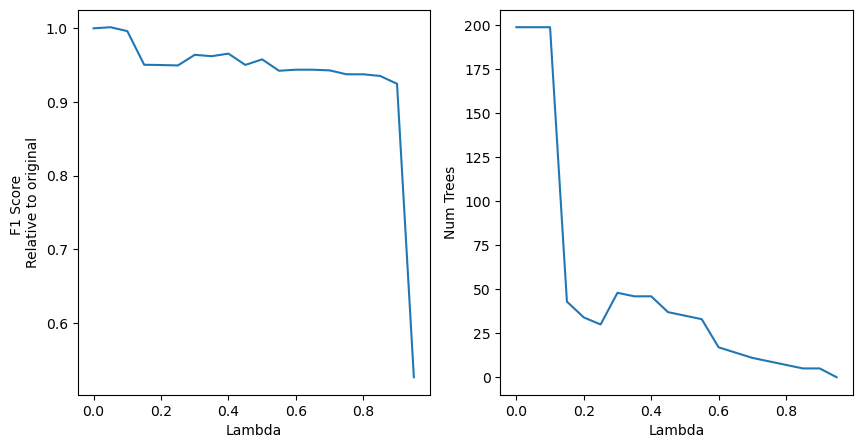

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(lams, [score/scores[0] for score in scores])
axs[0].set_xlabel('Lambda')
axs[0].set_ylabel(f'F1 Score \nRelative to original')

axs[1].plot(lams, trees)
axs[1].set_xlabel('Lambda')
axs[1].set_ylabel('Num Trees')

#fig.savefig('../Data/Data/Figures/inprocessing_summary_i.svg')

(0.7996410279547818, 1.25)

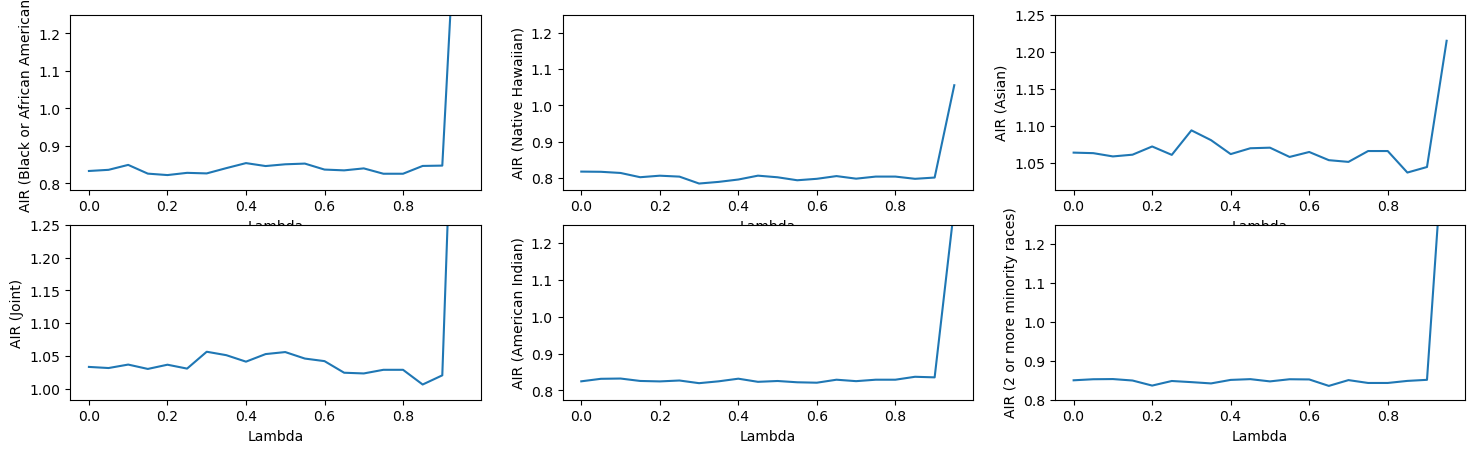

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(18, 5))
axs[0,0].plot(lams, air_black)
axs[0,0].set_xlabel('Lambda')
axs[0,0].set_ylabel('AIR (Black or African American)')
axs[0,0].set_ylim((air_black[0]-0.05, 1.25))

axs[0,1].plot(lams, air_Native_Hawaiian)
axs[0,1].set_xlabel('Lambda')
axs[0,1].set_ylabel('AIR (Native Hawaiian)')
axs[0,1].set_ylim((air_Native_Hawaiian[0]-0.05, 1.25))


axs[0,2].plot(lams, air_asian)
axs[0,2].set_xlabel('Lambda')
axs[0,2].set_ylabel('AIR (Asian)')
axs[0,2].set_ylim((air_asian[0]-0.05, 1.25))

axs[1,0].plot(lams, air_Joint)
axs[1,0].set_xlabel('Lambda')
axs[1,0].set_ylabel('AIR (Joint)')
axs[1,0].set_ylim((air_Joint[0]-0.05, 1.25))

axs[1,1].plot(lams, air_American_Indian)
axs[1,1].set_xlabel('Lambda')
axs[1,1].set_ylabel('AIR (American Indian)')
axs[1,1].set_ylim((air_American_Indian[0]-0.05, 1.25))

axs[1,2].plot(lams, air_more_minority)
axs[1,2].set_xlabel('Lambda')
axs[1,2].set_ylabel('AIR (2 or more minority races)')
axs[1,2].set_ylim((air_more_minority[0]-0.05, 1.25))

#fig.savefig('../Data/Data/Figures/inprocessing_summary_ii.png')

In [ ]:
# Conduct a similar experiment with the magnitude of the reweighing scheme.

magnitudes = np.arange(0, 1.5, 0.05)
scores = []
trees = []


air_black_ii = []
air_Native_Hawaiian_ii = []
air_asian_ii = []
air_Joint_ii = []
air_American_Indian_ii  = []
air_more_minority_ii  = []
air_Race_Not_Available_ii = []


dtest = xgb.DMatrix(test[features], label=test[target])

for mag in magnitudes:

    weight_change = 1 - train_weights
    new_train_weights = 1 - mag*weight_change

    dtrain = xgb.DMatrix(train[features],
                     label=train[target],
                     weight=new_train_weights)


    model = xgb.train(params,
                      dtrain,
                      num_boost_round=200,
                      evals=watchlist,
                      early_stopping_rounds=10,
                      verbose_eval=False)

    model_metrics = perf_metrics(y_true=valid[target],
                                 y_score=model.predict(dvalid, iteration_range=(0, model.best_iteration)))
    best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

    test[f'p_{target}_lam_test'] = model.predict(dtest, iteration_range=(0, model.best_iteration))

    air_table = fair_lending_disparity(test, y=target, yhat=f'p_{target}_lam_test',
                                       demo_name='derived_race', groups=race_levels, reference_group='White',
                                       cutoff=best_cut)

    scores.append(model_metrics['f1'].max())
    trees.append(model.best_iteration)


    air_black_ii.append(air_table.loc['Black or African American']['AIR'])
    air_Native_Hawaiian_ii.append(air_table.loc['Native Hawaiian or Other Pacific Islander']['AIR'])
    air_asian_ii.append(air_table.loc['Asian']['AIR'])
    air_Joint_ii.append(air_table.loc['Joint']['AIR'])
    air_American_Indian_ii.append(air_table.loc['American Indian or Alaska Native']['AIR'])
    air_more_minority_ii.append(air_table.loc['2 or more minority races']['AIR'])
    air_Race_Not_Available_ii.append(air_table.loc['Race Not Available']['AIR'])

Text(0, 0.5, 'Num Trees')

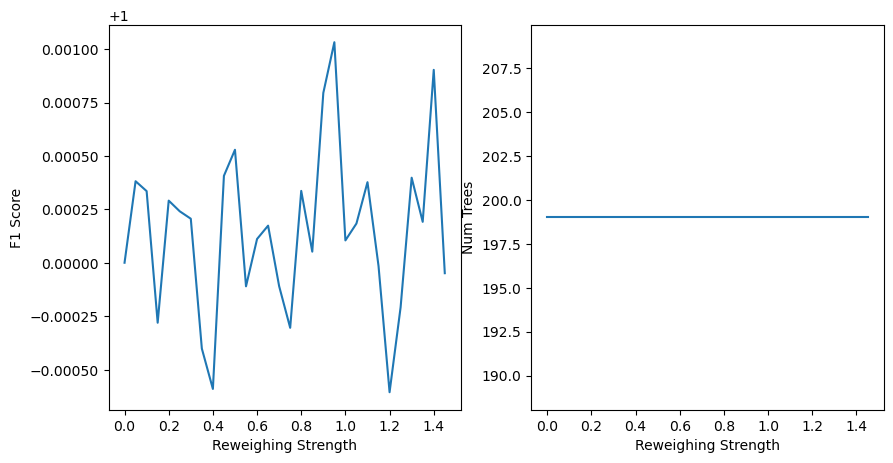

In [ ]:
# This plot shows a relative drop in F1 score down to 94% of the original value.
#  Meanwhile, black and Hispanic AIRs go from 0.72 to 0.9!

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(magnitudes, [score/scores[0] for score in scores])
axs[0].set_xlabel('Reweighing Strength')
axs[0].set_ylabel('F1 Score')

axs[1].plot(magnitudes, trees)
axs[1].set_xlabel('Reweighing Strength')
axs[1].set_ylabel('Num Trees')




#fig.savefig('../Data/Data/Figures/preprocessing_summary_i.svg')

(0.7996410279547818, 1.25)

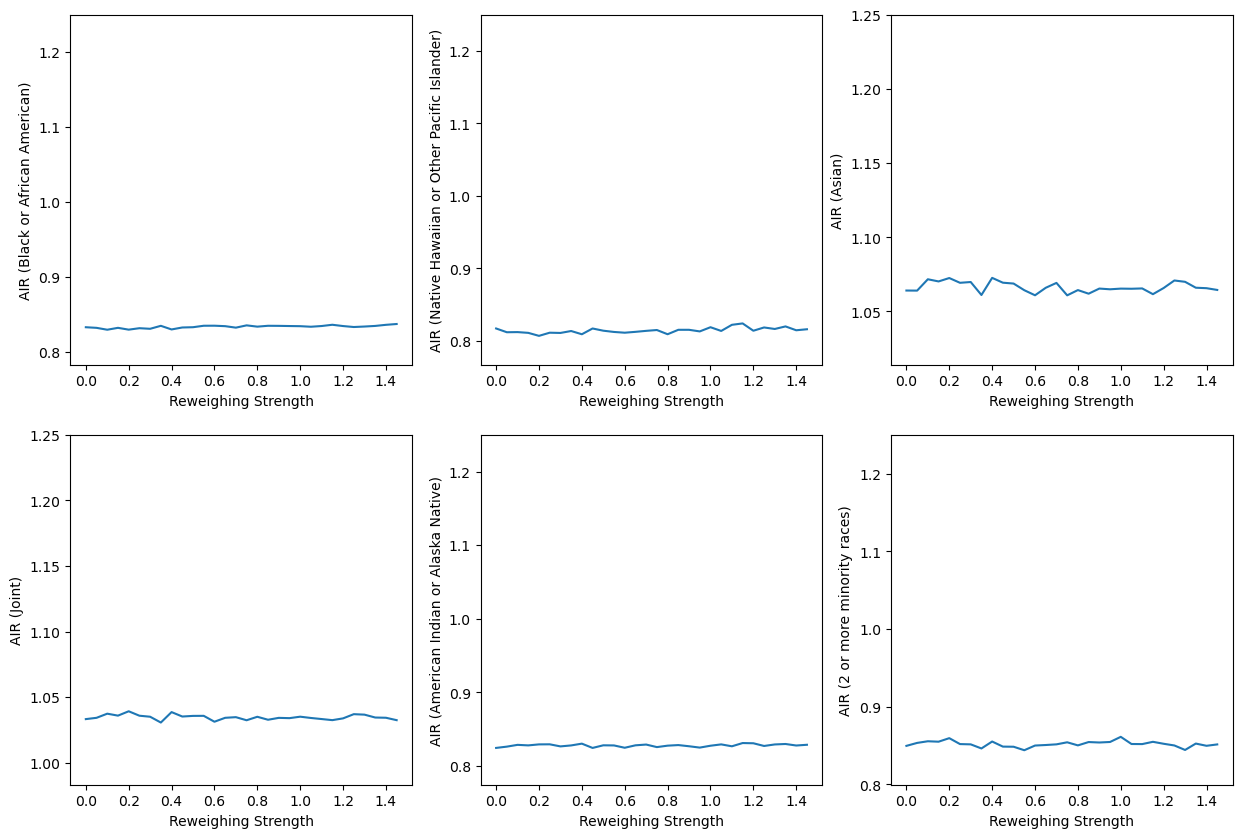

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

axs[0, 0].plot(magnitudes, air_black_ii)
axs[0, 0].set_xlabel('Reweighing Strength')
axs[0, 0].set_ylabel('AIR (Black or African American)')
axs[0, 0].set_ylim((air_black_ii[0]-0.05, 1.25))

axs[0, 1].plot(magnitudes, air_Native_Hawaiian_ii)
axs[0, 1].set_xlabel('Reweighing Strength')
axs[0, 1].set_ylabel('AIR (Native Hawaiian or Other Pacific Islander)')
axs[0, 1].set_ylim((air_Native_Hawaiian_ii[0]-0.05, 1.25))

axs[0, 2].plot(magnitudes, air_asian_ii)
axs[0, 2].set_xlabel('Reweighing Strength')
axs[0, 2].set_ylabel('AIR (Asian)')
axs[0, 2].set_ylim((air_asian_ii[0]-0.05, 1.25))

axs[1, 0].plot(magnitudes, air_Joint_ii)
axs[1, 0].set_xlabel('Reweighing Strength')
axs[1, 0].set_ylabel('AIR (Joint)')
axs[1, 0].set_ylim((air_Joint_ii[0]-0.05, 1.25))

axs[1, 1].plot(magnitudes, air_American_Indian_ii)
axs[1, 1].set_xlabel('Reweighing Strength')
axs[1, 1].set_ylabel('AIR (American Indian or Alaska Native)')
axs[1, 1].set_ylim((air_American_Indian_ii[0]-0.05, 1.25))

axs[1, 2].plot(magnitudes, air_more_minority_ii)
axs[1, 2].set_xlabel('Reweighing Strength')
axs[1, 2].set_ylabel('AIR (2 or more minority races)')
axs[1, 2].set_ylim((air_more_minority_ii[0]-0.05, 1.25))

#fig.savefig('../Data/Data/Figures/preprocessing_summary_ii.png')

### Post-Processing

In [ ]:
def reject_option_classification(frame, y_hat, demo_name, protected_groups, reference_group,
                                 cutoff, uncertainty_region_size, favorable_outcome=0):
    """
    In an uncertainty region around the decision cutoff value, flip protected group predictions to the
    favorable decision and reference group predictions to the unfavorable decision.
    """
    new_predictions = frame[y_hat].values.copy()

    uncertain = np.where(np.abs(frame[y_hat] - cutoff) <= uncertainty_region_size, 1, 0)
    uncertain_protected = np.where(uncertain & frame[demo_name].isin(protected_groups), 1, 0)
    uncertain_reference = np.where(uncertain & (frame[demo_name] == reference_group), 1, 0)

    eps = 1e-3

    if favorable_outcome == 0:
        new_predictions = np.where(uncertain_protected,
                                   cutoff - uncertainty_region_size - eps,
                                   new_predictions)
        new_predictions = np.where(uncertain_reference,
                                   cutoff + uncertainty_region_size + eps,
                                   new_predictions)
    else:
        new_predictions = np.where(uncertain_protected,
                                   cutoff + uncertainty_region_size + eps,
                                   new_predictions)
        new_predictions = np.where(uncertain_reference,
                                   cutoff - uncertainty_region_size - eps,
                                   new_predictions)

    return new_predictions

In [ ]:
train['p_action_taken_encoded_postprocessed'] = reject_option_classification(train, 'p_action_taken_encoded',
                                                                    'derived_race', ['Black or African American',
                                                                                     'Native Hawaiian or Other Pacific Islander',
                                                                                    'American Indian or Alaska Native',
                                                                                    '2 or more minority races'], 'White',
                                                                    best_cut_original, uncertainty_region_size=0.05,
                                                                    favorable_outcome=0)

valid['p_action_taken_encoded_postprocessed'] = reject_option_classification(valid, 'p_action_taken_encoded',
                                                                    'derived_race', ['Black or African American',
                                                                                     'Native Hawaiian or Other Pacific Islander',
                                                                                    'American Indian or Alaska Native',
                                                                                    '2 or more minority races'], 'White',
                                                                    best_cut_original, uncertainty_region_size=0.05,
                                                                    favorable_outcome=0)

test['p_action_taken_encoded_postprocessed'] = reject_option_classification(test, 'p_action_taken_encoded',
                                                                    'derived_race', ['Black or African American',
                                                                                     'Native Hawaiian or Other Pacific Islander',
                                                                                    'American Indian or Alaska Native',
                                                                                    '2 or more minority races'], 'White',
                                                                    best_cut_original, uncertainty_region_size=0.05,
                                                                    favorable_outcome=0)



### Show how post-processing adjusts or corrects the model's predictions after training

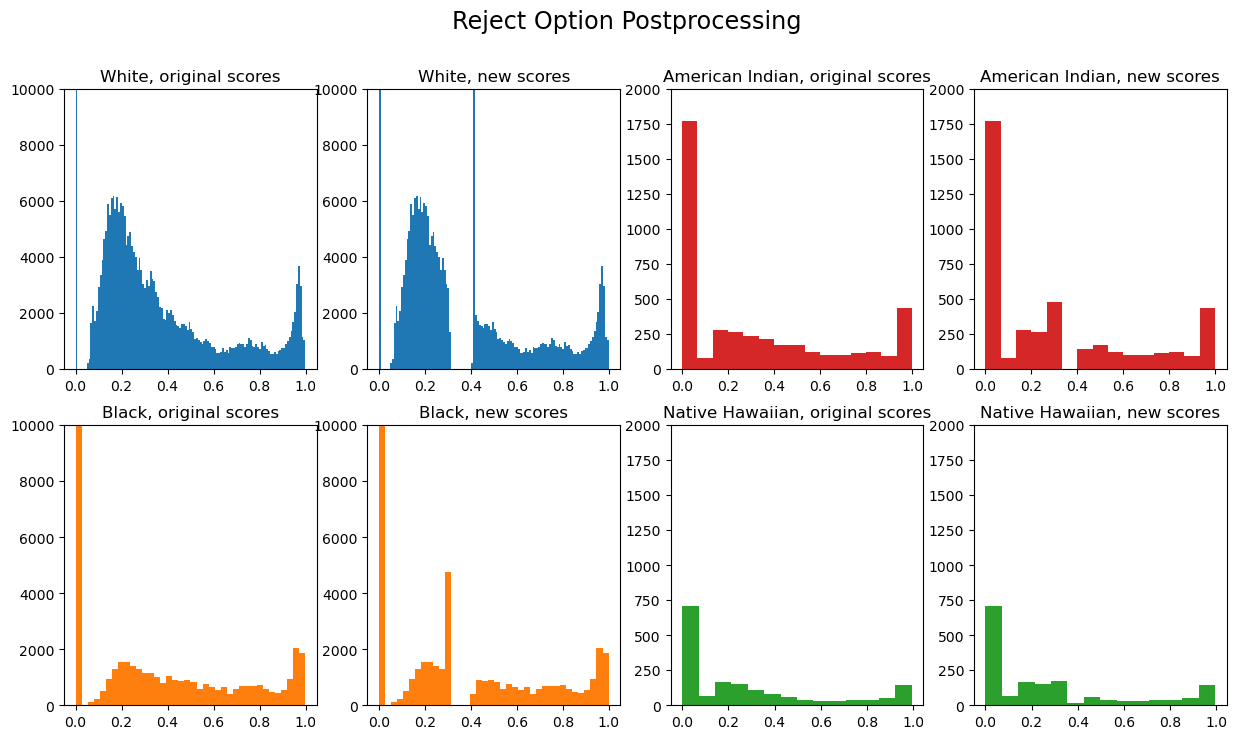

In [ ]:
fig, axs = plt.subplots(2, 4, figsize=(15, 8))

fig.suptitle('Reject Option Postprocessing', size='xx-large')

axs[0, 0].hist(train.loc[train['derived_race'] == 'White'][f'p_{target}'], bins='auto', color='C0')
axs[0, 0].set_title('White, original scores')
axs[0, 0].set_ylim([0, 10000])

axs[0, 1].hist(train.loc[train['derived_race'] == 'White'][f'p_{target}_postprocessed'], bins='auto', color='C0')
axs[0, 1].set_ylim([0, 10000])
axs[0, 1].set_title('White, new scores')


axs[1, 0].hist(train.loc[train['derived_race'] == 'Black or African American'][f'p_{target}'], bins='auto', color='C1')
axs[1, 0].set_title('Black, original scores')
axs[1, 0].set_ylim([0, 10000])

axs[1, 1].hist(train.loc[train['derived_race'] == 'Black or African American'][f'p_{target}_postprocessed'], bins='auto', color='C1')
axs[1, 1].set_ylim([0, 10000])
axs[1, 1].set_title('Black, new scores')


axs[1, 2].hist(train.loc[train['derived_race'] == 'Native Hawaiian or Other Pacific Islander'][f'p_{target}'], bins='auto', color='C2')
axs[1, 2].set_title('Native Hawaiian, original scores')
axs[1, 2].set_ylim([0, 2000])

axs[1, 3].hist(train.loc[train['derived_race'] == 'Native Hawaiian or Other Pacific Islander'][f'p_{target}_postprocessed'], bins='auto', color='C2')
axs[1, 3].set_title('Native Hawaiian, new scores')
axs[1, 3].set_ylim([0, 2000])


axs[0, 2].hist(train.loc[train['derived_race'] == 'American Indian or Alaska Native'][f'p_{target}'], bins='auto', color='C3')
axs[0, 2].set_title('American Indian, original scores')
axs[0, 2].set_ylim([0, 2000])

axs[0, 3].hist(train.loc[train['derived_race'] == 'American Indian or Alaska Native'][f'p_{target}_postprocessed'], bins='auto', color='C3')
axs[0, 3].set_ylim([0, 2000])
_ = axs[0, 3].set_title('American Indian, new scores')

#fig.savefig('../Data/Data/Figures/postprocessing_example.svg')
fig.savefig('postprocessing_example.svg')


### Post-processing(AIR)

In [ ]:
fair_lending_disparity(valid, y=target, yhat=f'p_{target}_postprocessed',
                       demo_name='derived_race', groups=race_levels, reference_group='White',
                       cutoff=best_cut)

,Count,Favorable Outcomes,Favorable Rate,Mean Score,Std Score,AIR,AIR p-value,SMD,SMD p-value
Race Not Available,28616,21421,0.748567,0.231941,0.279193,0.997480,5.141822e-01,0.076698,2.196071e-28
Black or African American,14211,9694,0.682148,0.289255,0.282174,0.908974,6.116766e-69,0.279005,1.323749e-157
Asian,10232,8539,0.834539,0.186536,0.273603,1.112038,2.149939e-80,-0.087684,1.000000e+00
Native Hawaiian or Other Pacific Islander,427,293,0.686183,0.309232,0.274245,0.914351,2.643351e-03,0.359915,7.130203e-09
Joint,3688,3038,0.823753,0.182156,0.273431,1.097666,3.908455e-24,-0.103759,1.000000e+00
American Indian or Alaska Native,1104,765,0.692935,0.287319,0.274507,0.923349,1.318214e-05,0.279745,1.742834e-14
2 or more minority races,370,249,0.672973,0.320702,0.274179,0.896749,7.321508e-04,0.401836,1.171530e-09
White,112867,84702,0.750459,0.210527,0.273878,1.000000,1.000000e+00,0.000000,5.000000e-01


In [ ]:
metrics = perf_metrics(y_true=valid[target],
                       y_score=valid[f'p_{target}_postprocessed'])

metrics.loc[metrics['cutoff'] == best_cut_original]


,cutoff,recall,precision,f1
36,0.36,0.753933,0.658102,0.702766


## 4. Model Selection

### Feature Selection

Feature selection is a powerful technique for debiasing. We'll look at the effect of dropping each feature in turn (We could also use the adversarial model we've already trained to inform which features we should drop).

In [ ]:
# We'll examine the effect of dropping each feature individually on model performance and adverse impact ratios.

features_to_drop = ['original model'] + features

In [ ]:
num_cv_folds = 5

# Build the custom cross-validation iterable.
all_indices = np.arange(0, len(train))
all_indices = np.random.permutation(all_indices)
splits = np.array([int(np.floor(len(train)/num_cv_folds)) for _ in range(num_cv_folds-1)])
splits = np.append(splits, len(train) - splits.sum())

test_indices = np.split(all_indices, splits.cumsum())[:-1]
test_groups = [train.iloc[test_ind]['derived_race'].values for test_ind in test_indices]

train_indices = [np.array([i for i in all_indices if i not in test_ind]) for test_ind in test_indices]

In [ ]:
feature_selection_results = pd.DataFrame(index=features_to_drop,
                                         columns=['AUC', 'Black or African American AIR',
                                                  'Native Hawaiian or Other Pacific Islander AIR',
                                                 'American Indian or Alaska Native AIR',
                                                 '2 or more minority races'])

for dropped_feature in features_to_drop:

    new_features = list(set(features).difference(set([dropped_feature])))

    cv_auc = []
    cv_black_air = []
    cv_Hawaiian_air = []
    cv_American_Indian_air = []
    cv_more_minority_air = []

    for fold_num, (train_ind, test_ind) in enumerate(zip(train_indices, test_indices)):

        new_monotone_constraints={k: v for k, v in dict(zip(features, monotone_constraints)).items() if k != dropped_feature}

        cv_model = xgb.XGBClassifier(n_estimators=150,
                                     max_depth=5,
                                     learning_rate=0.05,
                                     subsample=0.6,
                                     colsample_bytree=1.0,
                                     monotone_constraints=new_monotone_constraints,
                                     random_state=12345,
                                     use_label_encoder=False,
                                     base_score=params['base_score'],
                                     eval_metric='logloss')

        train_slice = train.reset_index(drop=True).iloc[train_ind].copy()
        test_slice = train.reset_index(drop=True).iloc[test_ind].copy()

        cv_model = cv_model.fit(train_slice[new_features],
                                train_slice[target])
        y_pred = cv_model.predict_proba(test_slice[new_features])[:, 1]


        model_metrics = perf_metrics(y_true=train[target].values[test_ind], y_score=y_pred)
        best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

        cv_auc.append(sklearn.metrics.roc_auc_score(y_true=train[target].values[test_ind],
                                                    y_score=y_pred))

        test_slice['pred'] = y_pred
        disparity_table = fair_lending_disparity(test_slice, y=target, yhat=f'pred',
                           demo_name='derived_race', groups=race_levels, reference_group='White',
                           cutoff=best_cut)

        cv_black_air.append(disparity_table.loc['Black or African American']['AIR'])
        cv_Hawaiian_air.append(disparity_table.loc['Native Hawaiian or Other Pacific Islander']['AIR'])
        cv_American_Indian_air.append(disparity_table.loc['American Indian or Alaska Native']['AIR'])
        cv_more_minority_air.append(disparity_table.loc['2 or more minority races']['AIR'])


    feature_selection_results.loc[dropped_feature] = [np.mean(cv_auc),
                                                      np.mean(cv_black_air),
                                                      np.mean(cv_Hawaiian_air),
                                                      np.mean(cv_American_Indian_air),
                                                      np.mean(cv_more_minority_air)]

### Show which feature causes the most bias: (property value)

In [ ]:
feature_to_drop = feature_selection_results.sort_values('Black or African American AIR').index[-1]
feature_to_drop

'property_value'

### Drop each feature and rank sequentially, resulting in a bias from low to high

In [ ]:
feature_selection_results.sort_values('Black or African American AIR')

,AUC,Black or African American AIR,Native Hawaiian or Other Pacific Islander AIR,American Indian or Alaska Native AIR,2 or more minority races
loan_purpose_1,0.928106,0.825253,0.899213,0.80567,0.81194
debt_to_income_ratio_50%-60%,0.924951,0.825279,0.878194,0.795495,0.800529
loan_term_360.0,0.92921,0.826374,0.903065,0.800756,0.821731
debt_to_income_ratio_above60%,0.917649,0.827239,0.87264,0.794367,0.805325
loan_purpose_31,0.929706,0.827779,0.897235,0.802027,0.815374
loan_term_180.0,0.929666,0.827788,0.892512,0.802838,0.81741
loan_term_480.0,0.929476,0.82821,0.896276,0.805855,0.815229
debt_to_income_ratio_less20%,0.929422,0.828243,0.895731,0.807675,0.820716
loan_term_240.0,0.929734,0.828252,0.895348,0.802659,0.817611
combined_loan_to_value_ratio,0.924515,0.828267,0.900098,0.804919,0.821842


In [ ]:
new_features = list(set(features).difference(set(['property_value'])))
new_monotone_constraints={k: v for k, v in dict(zip(features, monotone_constraints)).items() if k in new_features}

### Hyperparameter Tuning

In [ ]:
parameter_distributions = {
    'n_estimators': np.arange(10, 221, 30),
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': stats.uniform(0.01, 0.1),
    'subsample': stats.uniform(0.7, 0.3),
    'colsample_bytree': stats.uniform(0.5, 0.5),
    'reg_lambda': stats.uniform(0.1, 50),
    'monotone_constraints': [new_monotone_constraints],
    'base_score': [params['base_score']]
    }

In [ ]:
fold_number = -1

def black_air(y_true, y_pred):

    global fold_number
    fold_number = (fold_number + 1) % num_cv_folds

    model_metrics = perf_metrics(y_true, y_score=y_pred)
    best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

    data = pd.DataFrame({'derived_race': test_groups[fold_number],
                        'y_true': y_true,
                        'y_pred': y_pred},
                        index=np.arange(len(y_pred)))

    disparity_table = fair_lending_disparity(data, y='y_true', yhat='y_pred',
                       demo_name='derived_race', groups=race_levels, reference_group='White',
                       cutoff=best_cut)

    return disparity_table.loc['Black or African American']['AIR']


def Hawaiian_air(y_true, y_pred):

    global fold_number

    model_metrics = perf_metrics(y_true, y_score=y_pred)
    best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

    data = pd.DataFrame({'derived_race': test_groups[fold_number],
                        'y_true': y_true,
                        'y_pred': y_pred},
                        index=np.arange(len(y_pred)))

    disparity_table = fair_lending_disparity(data, y='y_true', yhat='y_pred',
                       demo_name='derived_race', groups=race_levels, reference_group='White',
                       cutoff=best_cut)

    return disparity_table.loc['Native Hawaiian or Other Pacific Islander']['AIR']


def American_Indian_air(y_true, y_pred):

    global fold_number

    model_metrics = perf_metrics(y_true, y_score=y_pred)
    best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

    data = pd.DataFrame({'derived_race': test_groups[fold_number],
                        'y_true': y_true,
                        'y_pred': y_pred},
                        index=np.arange(len(y_pred)))

    disparity_table = fair_lending_disparity(data, y='y_true', yhat='y_pred',
                       demo_name='derived_race', groups=race_levels, reference_group='White',
                       cutoff=best_cut)

    return disparity_table.loc['American Indian or Alaska Native']['AIR']


def more_minority_air(y_true, y_pred):

    global fold_number

    model_metrics = perf_metrics(y_true, y_score=y_pred)
    best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

    data = pd.DataFrame({'derived_race': test_groups[fold_number],
                        'y_true': y_true,
                        'y_pred': y_pred},
                        index=np.arange(len(y_pred)))

    disparity_table = fair_lending_disparity(data, y='y_true', yhat='y_pred',
                       demo_name='derived_race', groups=race_levels, reference_group='White',
                       cutoff=best_cut)

    return disparity_table.loc['2 or more minority races']['AIR']

scoring = {
        'AUC': 'roc_auc',
        'Black AIR': sklearn.metrics.make_scorer(black_air, needs_proba=True),
        'Hawaiian AIR': sklearn.metrics.make_scorer(Hawaiian_air, needs_proba=True),
        'American Indian AIR': sklearn.metrics.make_scorer(American_Indian_air, needs_proba=True),
        'More minority AIR': sklearn.metrics.make_scorer(more_minority_air, needs_proba=True)
    }

In [ ]:
grid_search = sklearn.model_selection.RandomizedSearchCV(xgb.XGBClassifier(random_state=12345,
                                                                           use_label_encoder=False,
                                                                           eval_metric='logloss'),
                                                         parameter_distributions,
                                                         n_iter=50,
                                                         scoring=scoring,
                                                         cv=zip(train_indices, test_indices),
                                                         refit=False,
                                                         error_score='raise').fit(train[new_features], train[target].values)
results = pd.DataFrame(grid_search.cv_results_)

## **Model selection distribution**

##Original model      : <font color="red">Red</font>

##Post-hyperparameter tuning: <font color="blue">Blue</font>

##Post-feature selection  : <font color="orange">Orange</font>

Text(0, 0.5, 'AUC (normalized)')

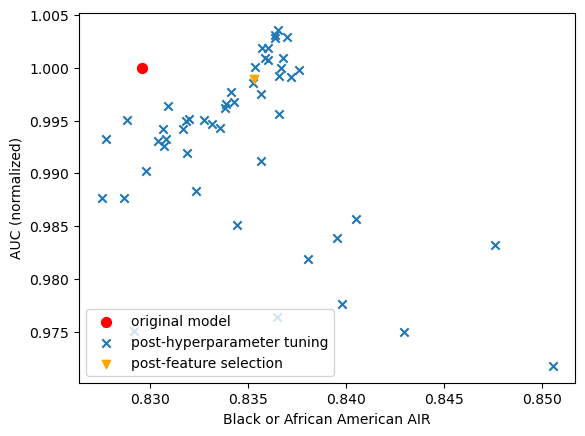

In [ ]:
original_auc = feature_selection_results.loc['original model']['AUC']
original_black_air = feature_selection_results.loc['original model']['Black or African American AIR']

new_auc = feature_selection_results.loc['property_value']['AUC']
new_black_air = feature_selection_results.loc['property_value']['Black or African American AIR']

fig, ax = plt.subplots()
ax.scatter(original_black_air, 1.0, s=50, color='red', label='original model')
ax.scatter(results['mean_test_Black AIR'], results['mean_test_AUC']/original_auc, label='post-hyperparameter tuning', marker='x')
ax.scatter(new_black_air, new_auc/original_auc, color='orange', label='post-feature selection', marker='v')
ax.legend(loc='lower left')
ax.set_xlabel('Black or African American AIR')
ax.set_ylabel('AUC (normalized)')

#fig.savefig('../Data/Data/Figures/model_tuning_scatter.svg', dpi=300)


### Hyperparameter Tuning 2
(same idea as Hyperparameter Tuning, but no more than a 1% decrease in AUC from the original model.)

In [ ]:

results[['mean_test_Black AIR',
         'mean_test_Hawaiian AIR',
         'mean_test_American Indian AIR',
         'mean_test_More minority AIR',
         'mean_test_AUC']].sort_values(['mean_test_Black AIR', 'mean_test_AUC'], ascending=False)

highest_air_idx = results.loc[results['mean_test_Black AIR'] == results['mean_test_Black AIR'].max()].index[0]

# We can also choose the fairest model that demonstrates no more than a 1% decrease in AUC from the original model.
business_viable_models = results.loc[results['mean_test_AUC'] >= 0.99*original_auc]
alternative_model_idx = business_viable_models.loc[business_viable_models['mean_test_Black AIR'] == business_viable_models['mean_test_Black AIR'].max()].index[0]


In [ ]:
new_hyperparameter_idx = [highest_air_idx, alternative_model_idx]

tuned_params = ['_'.join(col.split('_')[1:]) for col in results.columns if col.startswith('param_')]
new_hyperparameters = [dict(zip(tuned_params, [row[f'param_{param}'] for param in tuned_params])) for _, row in results.loc[new_hyperparameter_idx].iterrows()]

### Conclusion

In [ ]:
def model_summary(y_true, y_pred, group_info, reference_group, metric_dict, cutoff,
                  confusion_metrics_to_show=['False Positive Rate']):

    groups = np.unique(group_info)
    protected_groups = [group for group in groups if group != reference_group]

    model_metrics = perf_metrics(y_true, y_score=y_pred)
    # best_cut = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']
    # f1 = model_metrics['f1'].max()

    f1 = model_metrics.loc[model_metrics['cutoff'] == cutoff, 'f1'].values[0]

    auc = sklearn.metrics.roc_auc_score(y_true, y_score=y_pred)

    data = pd.DataFrame({'demo': group_info,
                        'y_true': y_true,
                        'y_pred': y_pred},
                        index=np.arange(len(y_pred)))

    disparity_table = fair_lending_disparity(data, y='y_true', yhat='y_pred',
                       demo_name='demo', groups=groups, reference_group=reference_group,
                       cutoff=cutoff)

    airs = dict(zip([f'{group} AIR' for group in protected_groups],
                    [disparity_table.loc[group]['AIR'] for group in protected_groups]))

    confusion_mats = {level: get_confusion_matrix(data, 'y_true', 'y_pred', by='demo',
                                                  level=level, cutoff=cutoff) for level in groups}
    confusion_metrics = confusion_matrix_metrics(confusion_mats, metric_dict)
    confusion_disparity_frame = confusion_metrics/confusion_metrics.loc[reference_group, :]

    confusion_metric_disparities = dict()
    for metric in confusion_metrics_to_show:
        confusion_metric_disparities.update(dict(zip([f"{group} {metric} Disparity" for group in protected_groups],
                                               [confusion_disparity_frame.loc[group][metric] for group in protected_groups])))

    output = {'AUC': auc, 'F1': f1}
    output.update(airs)
    output.update(confusion_metric_disparities)

    return pd.Series(output)

In [ ]:

feature_selection_model = xgb.XGBClassifier(n_estimators=150,
                                     max_depth=5,
                                     learning_rate=0.05,
                                     subsample=0.6,
                                     colsample_bytree=1.0,
                                     monotone_constraints=new_monotone_constraints,
                                     random_state=12345,
                                     use_label_encoder=False,
                                     base_score=params['base_score'],
                                     eval_metric='logloss').fit(train[new_features], train[target])

model_metrics = perf_metrics(y_true=valid[target],
                             y_score=feature_selection_model.predict_proba(valid[new_features])[:, 1])
best_cut_feature_selection = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

hyp_tuning_model_1 = xgb.XGBClassifier(random_state=12345,
                                     use_label_encoder=False,
                                     eval_metric='logloss', **new_hyperparameters[0]).fit(train[new_features], train[target])

model_metrics = perf_metrics(y_true=valid[target],
                             y_score=hyp_tuning_model_1.predict_proba(valid[new_features])[:, 1])
best_cut_hyp_1 = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']

hyp_tuning_model_2 = xgb.XGBClassifier(random_state=12345,
                                     use_label_encoder=False,
                                     eval_metric='logloss', **new_hyperparameters[1]).fit(train[new_features], train[target])


model_metrics = perf_metrics(y_true=valid[target],
                             y_score=hyp_tuning_model_2.predict_proba(valid[new_features])[:, 1])
best_cut_hyp_2 = model_metrics.loc[model_metrics['f1'].idxmax(), 'cutoff']


In [ ]:
model_predictions = {'Original Model': (test[f"p_{target}"].values, best_cut_original),
                    'Pre-processing (reweighting)': (test[f'p_{target}_reweighted'].values, reweighted_best_cut),
                    'In-processing (regularized, lam = 0.2)': (test[f'p_{target}_regularized'].values, best_cut_regularized),
                    'Post-processing (reject option, window size = 0.1)': (test[f'p_{target}_postprocessed'].values, best_cut_original),
                    'Feature selection': (feature_selection_model.predict_proba(test[new_features])[:, 1], best_cut_feature_selection),
                    'Hyperparameter tuning #1': (hyp_tuning_model_1.predict_proba(test[new_features])[:, 1], best_cut_hyp_1),
                    'Hyperparameter tuning #2': (hyp_tuning_model_2.predict_proba(test[new_features])[:, 1], best_cut_hyp_2)}

In [ ]:
model_summaries = {name: model_summary(test[target].values, pred, test['derived_race'].values, 'White', metric_dict, cutoff) for name, (pred, cutoff) in model_predictions.items()}

# **Final Results**

In [ ]:
pd.DataFrame(model_summaries)

,Original Model,Pre-processing (reweighting),"In-processing (regularized, lam = 0.2)","Post-processing (reject option, window size = 0.1)",Feature selection,Hyperparameter tuning #1,Hyperparameter tuning #2
AUC,0.931692,0.926868,0.917695,0.930999,0.929108,0.904146,0.930061
F1,0.711789,0.699388,0.674628,0.700524,0.704412,0.644520,0.706709
2 or more minority races AIR,0.849632,0.848854,0.844679,0.924020,0.853440,0.872563,0.850569
American Indian or Alaska Native AIR,0.824509,0.831641,0.813611,0.911480,0.833651,0.868095,0.834300
Asian AIR,1.063990,1.083521,1.086831,1.122605,1.058668,1.027205,1.063990
Black or African American AIR,0.833073,0.826994,0.817005,0.918266,0.837142,0.852060,0.838136
Joint AIR,1.033269,1.042641,1.046602,1.090192,1.030188,1.024976,1.033866
Native Hawaiian or Other Pacific Islander AIR,0.817190,0.795622,0.806370,0.886242,0.820556,0.816909,0.795707
Race Not Available AIR,0.952294,0.958607,0.963053,1.004756,0.948469,0.956384,0.949975
2 or more minority races False Positive Rate Disparity,0.957476,0.875927,0.884702,0.640568,1.020559,1.282761,1.093849


**Preprocessing (Reweighting), In Processing (Regularization, lam = 0.2), and Postprocessing (Reject Option, Window Size = 0.1):** More for academic use, probably illegal in the real world.


**Feature selection and hyperparameter tuning:** More commonly used in the real world.

Methods with higher AUC and AIR are better choices.